In [1]:
import math
import itertools
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
pd.set_option('display.max_columns', None)

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
data = pd.read_csv("/content/drive/MyDrive/Trabajo profesional/Code/data/prod_clean_2024-05-27_01:43:41.csv", index_col=0, low_memory=False)
data["fecha"] = data['fecha'].astype('datetime64[ns]')
data.insert(4, "prod", np.where(data["tipopozo"] == "Petrolífero", data["prod_pet"], data["prod_gas"]))
data.insert(2, "periodo", 0) # To use later when generating period column
data.sort_values(by=['fecha', 'idpozo'], ascending=True, inplace=True)
data.reset_index(drop=True, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146260 entries, 0 to 146259
Data columns (total 35 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   idempresa                146260 non-null  object        
 1   fecha                    146260 non-null  datetime64[ns]
 2   periodo                  146260 non-null  int64         
 3   anio                     146260 non-null  int64         
 4   mes                      146260 non-null  int64         
 5   prod                     146260 non-null  float64       
 6   idpozo                   146260 non-null  int64         
 7   tipopozo                 146260 non-null  object        
 8   prod_pet                 146260 non-null  float64       
 9   prod_gas                 146260 non-null  float64       
 10  prod_agua                146260 non-null  float64       
 11  tef                      146260 non-null  float64       
 12  tipoextraccion  

In [4]:
data.describe(percentiles=[.25, .5, .75, .95])

fecha   periodo           anio            mes  \
count                         146260  146260.0  146260.000000  146260.000000   
mean   2020-06-21 14:11:51.040612608       0.0    2020.015807       6.492568   
min              2014-01-01 00:00:00       0.0    2014.000000       1.000000   
25%              2018-08-01 00:00:00       0.0    2018.000000       3.000000   
50%              2020-10-01 00:00:00       0.0    2020.000000       7.000000   
75%              2022-09-01 00:00:00       0.0    2022.000000      10.000000   
95%              2023-12-01 00:00:00       0.0    2023.000000      12.000000   
max              2024-03-01 00:00:00       0.0    2024.000000      12.000000   
std                              NaN       0.0       2.513826       3.497196   

                prod         idpozo       prod_pet       prod_gas  \
count  146260.000000  146260.000000  146260.000000  146260.000000   
mean     1358.899054  157217.504820     438.267869    1040.886781   
min         0.000000  146212.000000       0.000000       0.000000   
25%       210.741500  154924.000000       0.407152     111.429650   
50%       586.085000  157867.000000      40.040000     327.704500   
75%      1587.693000  160057.000000     337.487025     962.175950   
95%      5399.136900  163069.000000    2434.084000    4817.321950   
max     29129.660000  164500.000000   16513.300000   29129.660000   
std      2081.132808    4221.254789     999.825974    1998.587737   

           prod_agua            tef    profundidad    coordenadax  \
count  146260.000000  146260.000000  146260.000000  146260.000000   
mean      233.829789      27.029363    3736.658692     -68.842013   
min         0.000000       0.000000       0.000000     -71.357210   
25%         8.700000      27.380000    2879.000000     -69.166957   
50%        44.463500      29.850000    3740.000000     -68.866871   
75%       174.750000      30.770000    4836.000000     -68.512013   
95%      1140.996500      31.000000    5853.000000     -67.874271   
max     17468.160000      79.340000    7535.000000     -38.590070   
std       593.912400       6.787908    1382.954720       0.789717   

         coordenaday           cota  adjiv_capacidad_perf  adjiv_comp_perf  
count  146260.000000  146260.000000         143254.000000    146032.000000  
mean      -39.147365     477.744050           3860.940865        11.033246  
min       -69.415770      28.380000              0.000000         0.000000  
25%       -38.752442     373.530000           3000.000000         5.000000  
50%       -38.541111     480.370000           4500.000000        11.000000  
75%       -38.331752     546.670000           5000.000000        17.000000  
95%       -38.022553     714.340000           6100.000000        21.000000  
max       -24.116560    1816.590000          36000.000000        29.000000  
std         2.786917     152.704921           2125.870929         7.237225

In [5]:
prod_data = data[["idpozo", "fecha", "periodo", "prod", "prod_pet", "prod_gas", "tipopozo"]].copy(deep=True)
prod_data.head(5)

idpozo      fecha  periodo    prod  prod_pet  prod_gas     tipopozo
0  146212 2014-01-01        0  100.24    100.24     24.80  Petrolífero
1  146213 2014-01-01        0  102.16    102.16     28.79  Petrolífero
2  146214 2014-01-01        0  438.05    438.05     51.28  Petrolífero
3  146215 2014-01-01        0  148.10    148.10     32.34  Petrolífero
4  146216 2014-01-01        0  716.02      0.00    716.02     Gasífero

### Utils functions

In [6]:
def get_prod_by_well_id(id):
  return prod_data[prod_data["idpozo"] == id]

def get_well_id_type(id):
  return prod_data[prod_data["idpozo"] == id]["tipopozo"].iloc[0]

def get_well_min_valid_prod(id):
  MIN_VALID_MONTHLY_PROD = 40
  MIN_MEAN_PROPORTION = 1/3

  return max([MIN_VALID_MONTHLY_PROD, prod_data[prod_data["idpozo"] == id]["prod"].mean() * MIN_MEAN_PROPORTION])

def add_min_prod_line_to_axis(ax, min_value_prod):
  min_prod_line = ax.axhline(y=min_value_prod, linewidth=0.6, color='r', alpha=0.9, linestyle='--')
  min_prod_line.set_label('min_valid_prod')
  ax.legend(loc='best')

def plot_well_id(id, desc="", axvspans=[], show_min_valid_prod=True):
  well_prod = prod_data[prod_data["idpozo"] == id]
  well_type = well_prod["tipopozo"].iloc[0]

  fig, ax = plt.subplots()
  fig.set_size_inches(8, 3)
  fig.suptitle(f"Producción #{id}: " + ("Petróleo" if well_type == "Petrolífero" else "Gas") + f" {desc}", fontsize=12)

  ax.set_ylabel("m3" if well_type == "Petrolífero" else "miles de m3")
  well_prod.plot(ax=ax, x="fecha", y="prod_pet" if well_type == "Petrolífero" else "prod_gas", grid=True)

  if show_min_valid_prod:
    add_min_prod_line_to_axis(ax=ax, min_value_prod=get_well_min_valid_prod(id))

  for a in axvspans:
    if a["prod"] == "pet":
      ax.axvspan(a["date_from"], a["date_to"], alpha=a["alpha"], color=a["color"])
    elif a["prod"] == "gas":
      ax.axvspan(a["date_from"], a["date_to"], alpha=a["alpha"], color=a["color"])

def plot_original_data_well_id(id, desc="", show_min_valid_prod=True):
  well_prod = data[data["idpozo"] == id]
  well_type = well_prod["tipopozo"].iloc[0]

  fig, ax = plt.subplots()
  fig.set_size_inches(8, 3)
  fig.suptitle(f"Producción original #{id}: " + ("Petróleo" if well_type == "Petrolífero" else "Gas") + f" {desc}", fontsize=12)

  ax.set_ylabel("m3" if well_type == "Petrolífero" else "miles de m3")
  well_prod.plot(ax=ax, x="fecha", y="prod_pet" if well_type == "Petrolífero" else "prod_gas", grid=True)

  if show_min_valid_prod:
    add_min_prod_line_to_axis(ax=ax, min_value_prod=get_well_min_valid_prod(id))

def delete_wells_ids(ids):
  global prod_data
  prod_data = prod_data.loc[~prod_data['idpozo'].isin(ids)]

def delete_index_ids(ids):
  global prod_data
  prod_data.drop(ids, inplace=True)

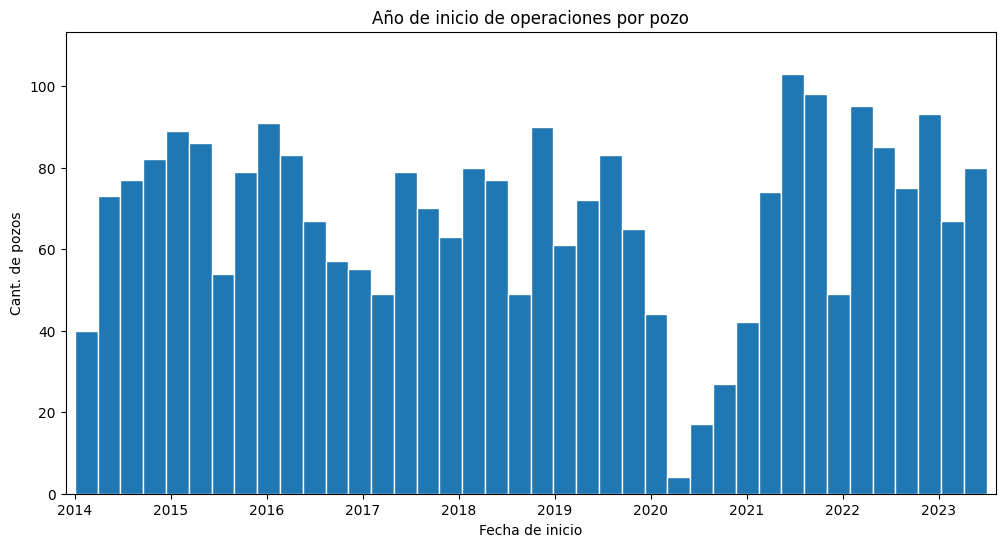

In [7]:
wells_min_date = prod_data.groupby(by=["idpozo"])["fecha"].min()
wells_min_date.hist(grid=False, bins=40, edgecolor='white', figsize=(12, 6))
plt.xlabel("Fecha de inicio")
plt.ylabel("Cant. de pozos")
plt.title('Año de inicio de operaciones por pozo')
plt.margins(x=0.01, y=0.1)
plt.show()
del(wells_min_date)

### Vistazo inicial a las curvas de producción de distintos pozos aleatorios

In [8]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]


def plot_mini_wells_sample(wells_ids_sample, title="", title_color="", num_cols=5, show_min_valid_prod=True):
  if num_cols < 2:
    raise Exception("Use 2 or more columns to display")

  # Params
  sample_amount = len(wells_ids_sample)
  fig_width = 25
  fig_height = 3 * math.ceil(sample_amount/num_cols)
  num_rows = math.ceil(sample_amount/num_cols)

  # Title workaround
  fig, ax = plt.subplots()
  fig.set_size_inches(fig_width, 0.5)
  fig.suptitle(title, fontsize=20)
  ax.set_axis_off()
  if title_color != "":
    fig.patch.set_facecolor(title_color)

  # Curve graphics
  fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols)
  fig.set_size_inches(fig_width, fig_height)
  fig.tight_layout(pad=3.0)
  fig.subplots_adjust(top=1.4)

  for row, chunk in enumerate(list(chunks(wells_ids_sample, num_cols))):
    for col, id in enumerate(chunk):
      well_prod = prod_data[prod_data["idpozo"] == id]
      well_type = well_prod["tipopozo"].iloc[0]

      if num_rows == 1:
        ax = axes[col]
      else:
        ax = axes[row][col]

      ax.set_title(f"Producción #{id}: " + ("Petróleo" if well_type == "Petrolífero" else "Gas"))
      ax.set_ylabel("m3" if well_type == "Petrolífero" else "miles de m3")

      well_prod.plot(ax=ax, x="fecha", y="prod_pet" if well_type == "Petrolífero" else "prod_gas", grid=True)

      if show_min_valid_prod:
        add_min_prod_line_to_axis(ax=ax, min_value_prod=get_well_min_valid_prod(id))

In [9]:
sample = random.sample(prod_data['idpozo'].value_counts().index.to_list(), k=60)
title = f"Muestra aleatoria de {len(sample)} pozos de un total de {len(prod_data['idpozo'].unique())} pozos únicos en el dataset"
plot_mini_wells_sample(wells_ids_sample=sample, title=title)

Output hidden; open in https://colab.research.google.com to view.

### Interpolación de valores por debajo de MIN_VALID_PROD

In [10]:
def interpolate_well_id(id, method="linear", order=2, min_valid_prod=None):
  global prod_data

  min_prod = min_valid_prod if min_valid_prod != None else get_well_min_valid_prod(id)
  well_id_mask = prod_data["idpozo"] == id
  new_prod_data = prod_data[well_id_mask]["prod"].apply(lambda x: np.nan if x <= min_prod else x).interpolate(method=method, order=order)
  prod_data.loc[well_id_mask, "prod"] = new_prod_data
  prod_type = "prod_pet" if get_well_id_type(id) == "Petrolífero" else "prod_gas"
  prod_data.loc[well_id_mask, prod_type] = new_prod_data
  prod_data = prod_data[~prod_data["prod"].isna()]

#### Ejemplo de distintos métodos de interpolación

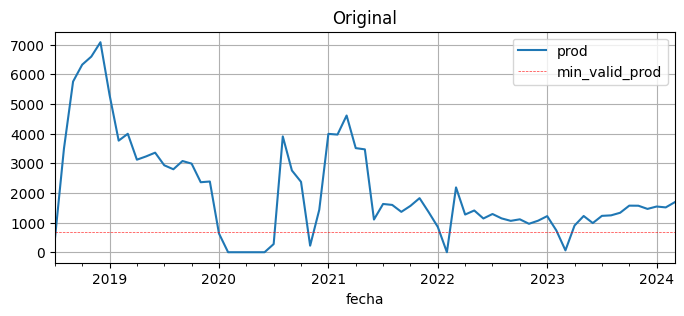

In [51]:
peek_well_id = 159500
peek_well_min_prod = get_well_min_valid_prod(peek_well_id)

fig, ax = plt.subplots()
fig.set_size_inches(8, 3)

get_prod_by_well_id(peek_well_id)[["prod", "fecha"]] \
  .plot(ax=ax, x="fecha", y="prod", grid=True)

min_prod_line = plt.axhline(y=peek_well_min_prod, linewidth=0.5, color='r', alpha=0.8, linestyle='--')
min_prod_line.set_label('min_valid_prod')
ax.legend(loc='best')

plt.title("Original")
plt.show()

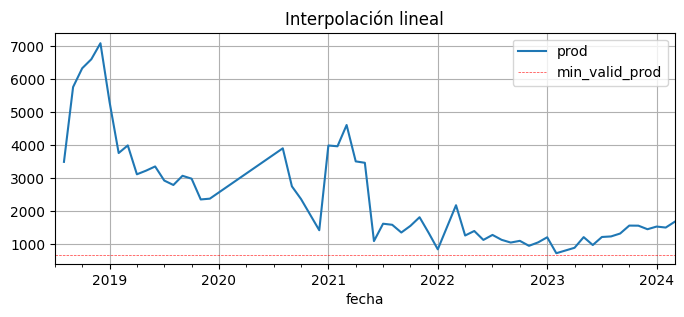

In [52]:
interpolation = get_prod_by_well_id(peek_well_id)["prod"] \
  .apply(lambda x: np.nan if x <= peek_well_min_prod else x) \
  .interpolate(method="linear")

fig, ax = plt.subplots()
fig.set_size_inches(8, 3)

pd.DataFrame(interpolation) \
  .merge(get_prod_by_well_id(peek_well_id)[["fecha"]], left_index=True, right_index=True) \
  .plot(ax=ax, x="fecha", y="prod", grid=True)

min_prod_line = plt.axhline(y=peek_well_min_prod, linewidth=0.5, color='r', alpha=0.8, linestyle='--')
min_prod_line.set_label('min_valid_prod')
ax.legend(loc='best')
plt.title("Interpolación lineal")
plt.show()

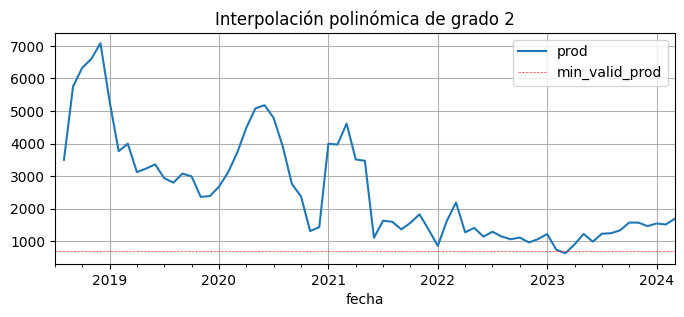

In [53]:
interpolation = get_prod_by_well_id(peek_well_id)["prod"] \
  .apply(lambda x: np.nan if x <= peek_well_min_prod else x) \
  .interpolate(method="polynomial", order=2) \

fig, ax = plt.subplots()
fig.set_size_inches(8, 3)

pd.DataFrame(interpolation) \
  .merge(get_prod_by_well_id(peek_well_id)[["fecha"]], left_index=True, right_index=True) \
  .plot(ax=ax, x="fecha", y="prod", grid=True)

min_prod_line = plt.axhline(y=peek_well_min_prod, linewidth=0.5, color='r', alpha=0.8, linestyle='--')
min_prod_line.set_label('min_valid_prod')
ax.legend(loc='best')
plt.title("Interpolación polinómica de grado 2")
plt.show()

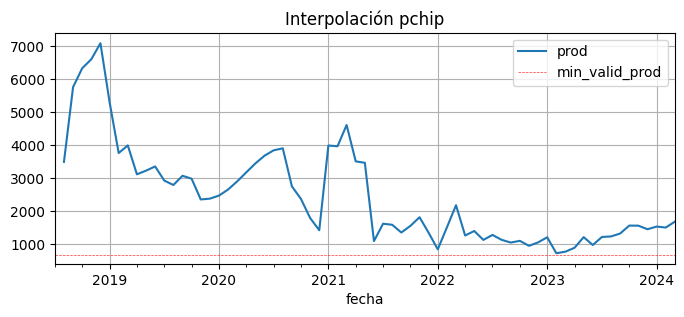

In [54]:
interpolation = get_prod_by_well_id(peek_well_id)["prod"] \
  .apply(lambda x: np.nan if x <= peek_well_min_prod else x) \
  .interpolate(method="pchip") \

fig, ax = plt.subplots()
fig.set_size_inches(8, 3)

pd.DataFrame(interpolation) \
  .merge(get_prod_by_well_id(peek_well_id)[["fecha"]], left_index=True, right_index=True) \
  .plot(ax=ax, x="fecha", y="prod", grid=True)

min_prod_line = plt.axhline(y=peek_well_min_prod, linewidth=0.5, color='r', alpha=0.8, linestyle='--')
min_prod_line.set_label('min_valid_prod')
ax.legend(loc='best')
plt.title("Interpolación pchip")
plt.show()

In [55]:
for i in range(10):
  sample_ids = random.sample(prod_data['idpozo'].value_counts().index.to_list(), k=4)
  plot_mini_wells_sample(wells_ids_sample=sample_ids, title="Before", num_cols=4, title_color='skyblue')

  for id in sample_ids:
    interpolate_well_id(id, method="linear")

  plot_mini_wells_sample(wells_ids_sample=sample_ids, title="After", num_cols=4)

Output hidden; open in https://colab.research.google.com to view.

#### Aplicación a todos los pozos

In [56]:
%%time

# Sorted by date is necessary condition
prod_data.sort_values(by=['fecha', 'idpozo'], ascending=True, inplace=True)
wells_ids = prod_data['idpozo'].value_counts().index.to_list()

for id in wells_ids:
  interpolate_well_id(id, method="linear")

CPU times: user 24.9 s, sys: 71.5 ms, total: 24.9 s
Wall time: 25.1 s


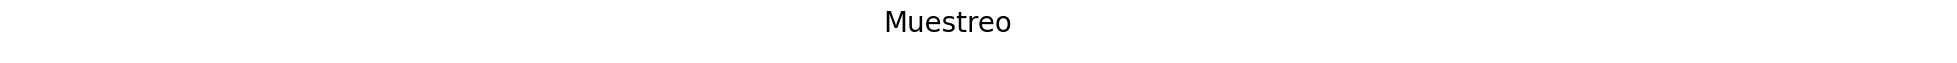

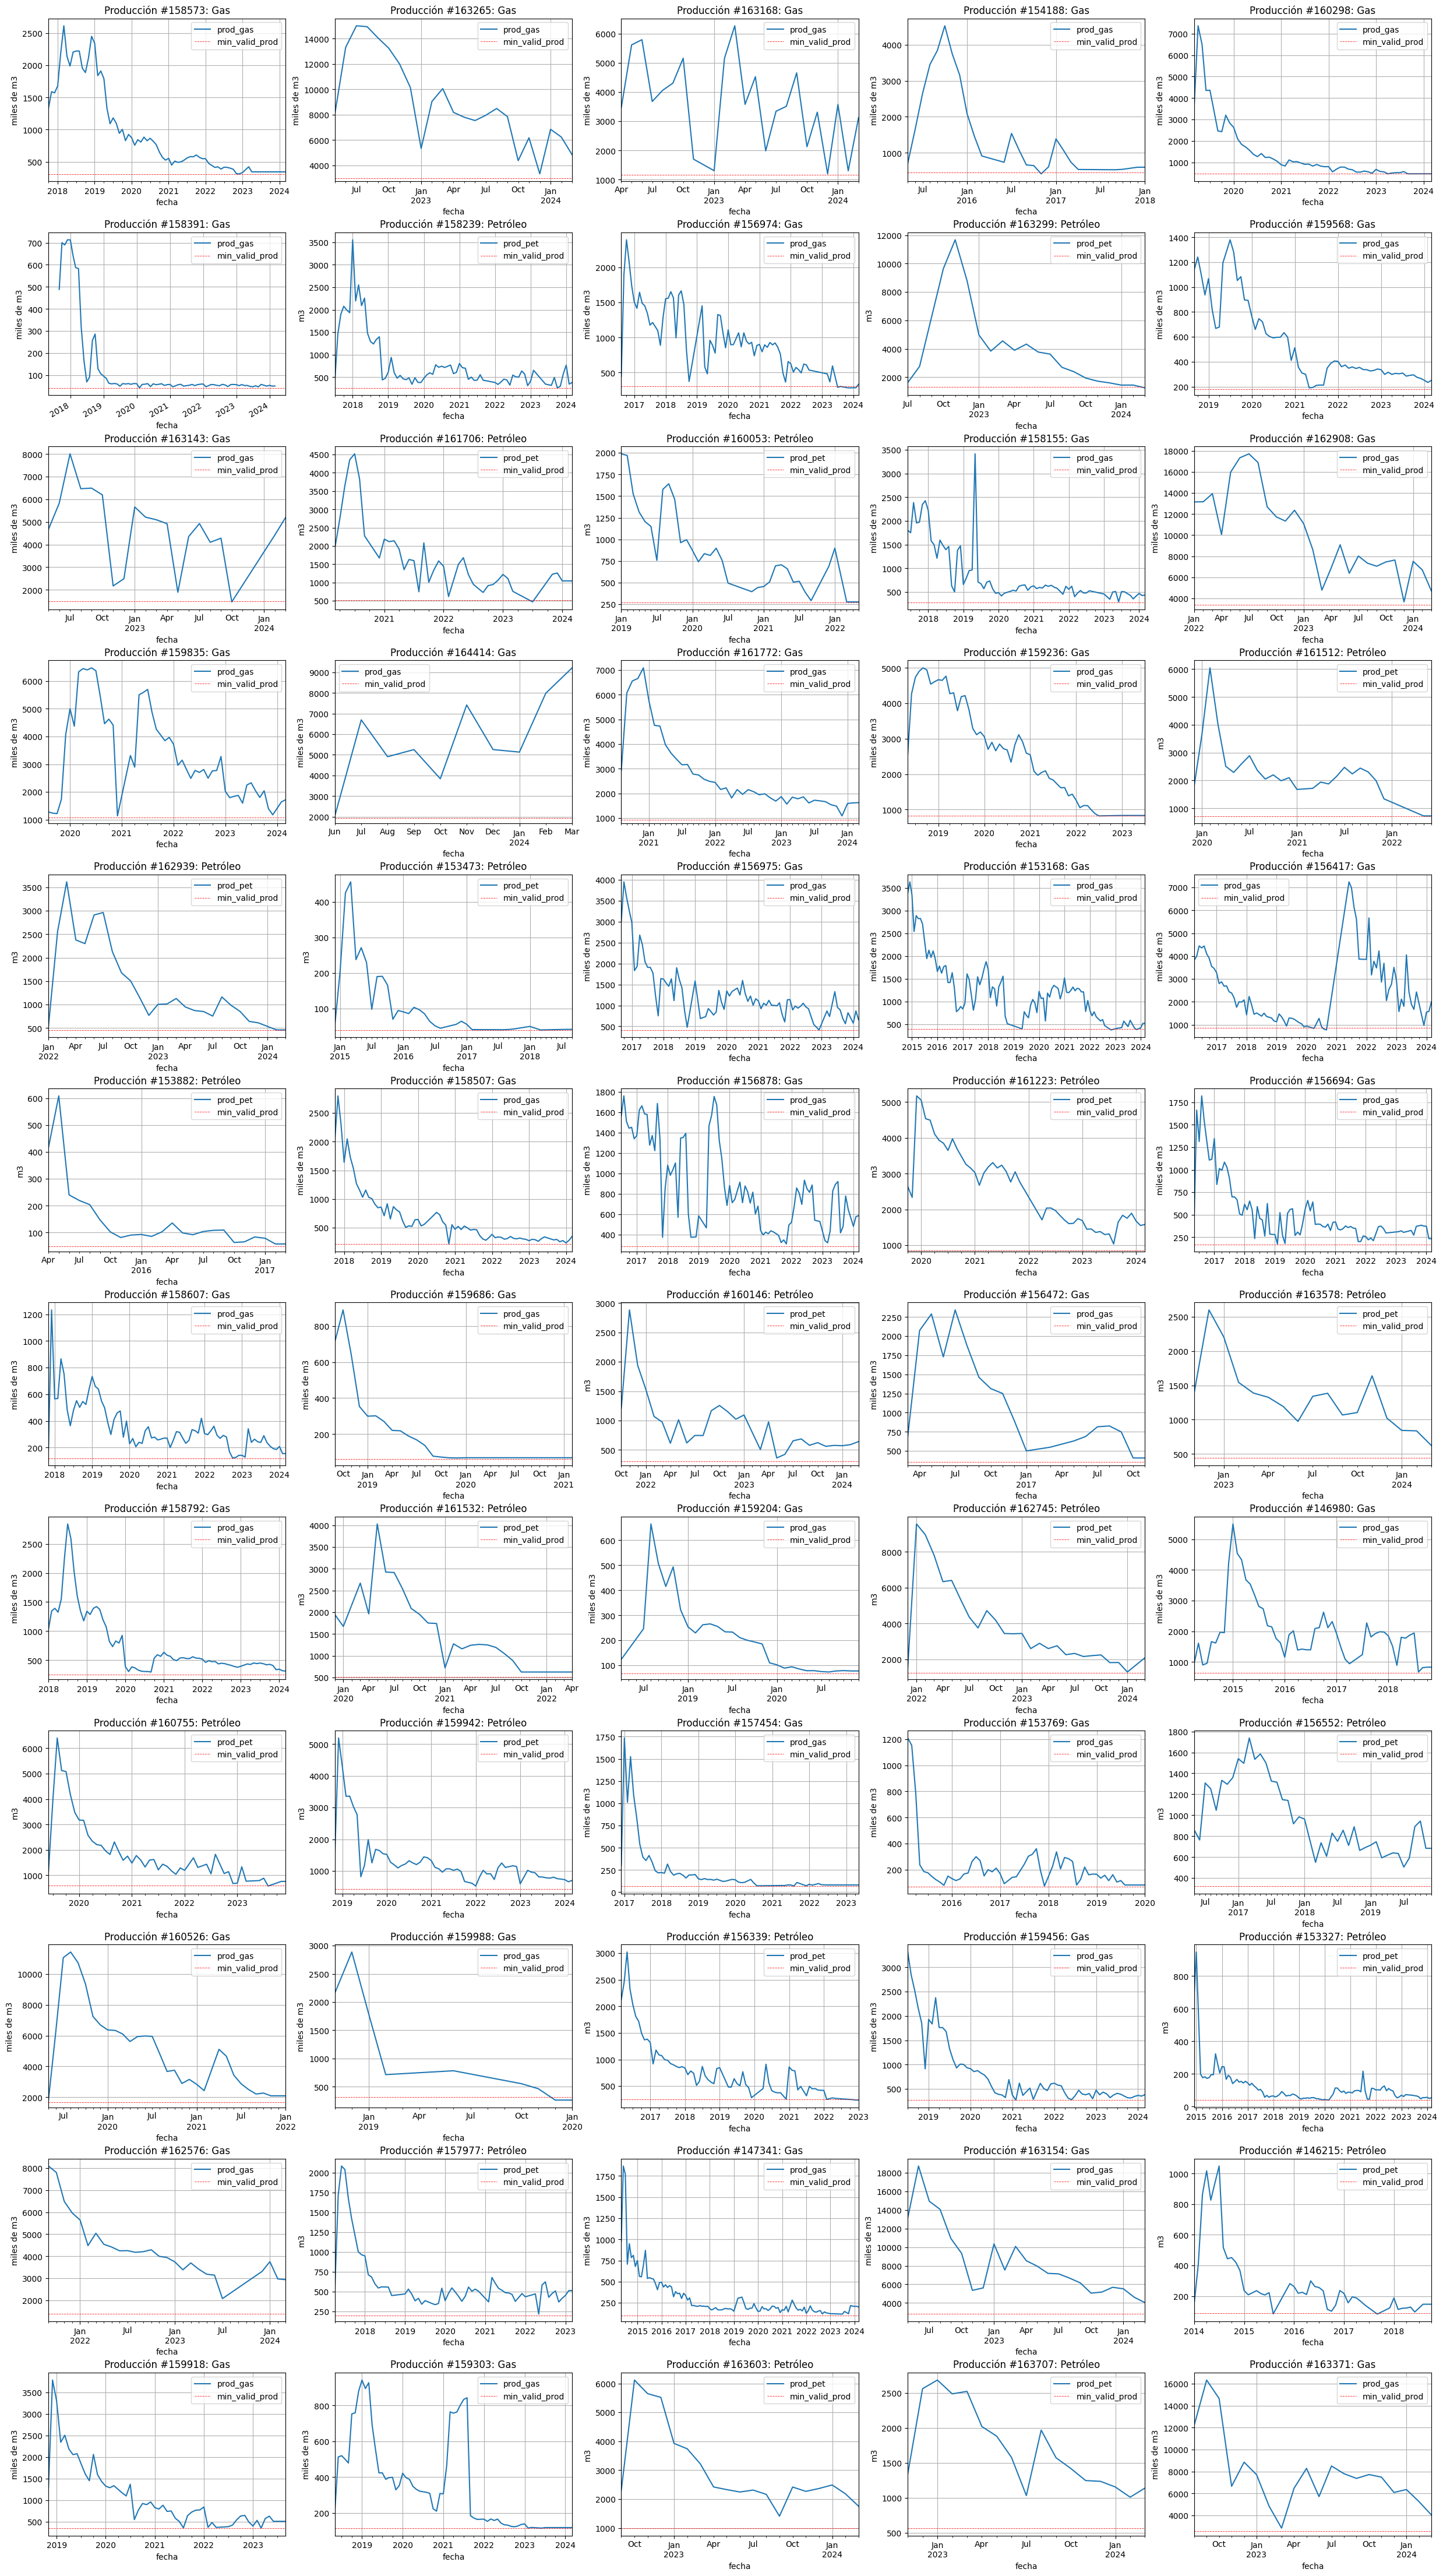

In [57]:
sample = random.sample(prod_data['idpozo'].value_counts().index.to_list(), k=60)
plot_mini_wells_sample(wells_ids_sample=sample, title="Muestreo")

### Se descartan las entradas que contengan cero (o ~cero) de producción por delante y por detras de la serie con entradas productivas (leading & trailing zeros or ~zeros)

In [58]:
def remove_well_id_zeros_ends(id, debug=False, leave_last_n_zero_months=1):
  APPLY_MIN_MONTHLY_PROD = get_well_min_valid_prod(id)

  well_prod = prod_data[prod_data["idpozo"] == id]
  valid_entries_mask = (well_prod["prod"] > APPLY_MIN_MONTHLY_PROD)
  well_prod_filtered = well_prod[valid_entries_mask].sort_values(by=['fecha'], ascending=True)

  if len(well_prod_filtered) == 0:
    # No valid entries, then we delete the entire well
    remove_index = well_prod.index
    delete_index_ids(remove_index)
    return len(remove_index)

  first_entry_date = well_prod_filtered['fecha'].head(1).iloc[0]
  last_entry_date = well_prod_filtered['fecha'].tail(1).iloc[0] + pd.DateOffset(months=leave_last_n_zero_months) # we leave last month with zero or ~zero production

  if debug:
    print("First entry date:\n", well_prod_filtered.head(1))
    print("\nLast entry date:\n", well_prod_filtered.tail(1))

  remove_condition_mask = ~(well_prod["fecha"].between(first_entry_date, last_entry_date))
  remove_index = well_prod[remove_condition_mask].index

  if len(remove_index) == 0:
    return 0

  delete_index_ids(remove_index)
  return len(remove_index)

def remove_wells_zeros_ends(leave_last_n_zero_months=1):
  print("Removing wells zeros ends...\n")

  wells_ids = prod_data['idpozo'].value_counts().index.to_list()

  removed_entries = 0
  affected_wells = 0

  for id in wells_ids:
    res = remove_well_id_zeros_ends(id, leave_last_n_zero_months=leave_last_n_zero_months)
    removed_entries += res
    affected_wells += 1 if res > 0 else 0

  print(f"Total removed entries: {removed_entries}")
  print(f"Total affected wells: {affected_wells}\n")

In [59]:
%%time
remove_wells_zeros_ends(leave_last_n_zero_months=1)

Removing wells zeros ends...

Total removed entries: 1100
Total affected wells: 176

CPU times: user 13.2 s, sys: 36.5 ms, total: 13.2 s
Wall time: 13.4 s


### Pozos con pocas entradas mensuales resultantes

In [60]:
MIN_MONTHLY_ENTRIES_COUNT = 9

def remove_wells_by_min_entries_count(min_entries_count):
  print(f"Filtering wells with less than {min_entries_count} entries...\n")

  result = prod_data.groupby(["idpozo"]).count()
  result = result[result["fecha"] < min_entries_count]
  wells_ids = result.index.to_list()
  delete_wells_ids(wells_ids)

  print(f"\nDeleted {len(wells_ids)} wells ids: {wells_ids}\n")

In [61]:
remove_wells_by_min_entries_count(min_entries_count=MIN_MONTHLY_ENTRIES_COUNT)

Filtering wells with less than 9 entries...


Deleted 5 wells ids: [160427, 164005, 164401, 164411, 164474]



### Pozos con total de producción cero (o ~cero)

In [62]:
def filter_wells_with_zero_total_production():
  print(f"Filtering wells with all production entries zero or ~zero...\n")

  MIN_VALID_TOTAL_PROD = 250

  result = prod_data.groupby(["idpozo"])[["prod"]].max()
  result = result[result["prod"] < MIN_VALID_TOTAL_PROD]
  wells_ids = result.index.to_list()

  delete_wells_ids(wells_ids)

  print(result)
  print(f"\nDeleted {len(wells_ids)} wells ids: {wells_ids}\n")

In [63]:
filter_wells_with_zero_total_production()

Filtering wells with all production entries zero or ~zero...

Empty DataFrame
Columns: [prod]
Index: []

Deleted 0 wells ids: []



### Analizamos qué tratamiento darle a períodos extensos sin producción


In [64]:
class ProductionPeriod:
  def __init__(self, min_prod):
    self.index_from = 0
    self.index_to = 0
    self.date_from = ""
    self.date_to = ""
    self.prod_sum = 0
    self.len = 0
    self.valid_min_prod = min_prod

  def append(self, prod_type, index, row):
    if self.index_from == 0:
      self.index_from = index
      self.date_from = row["fecha"]

    self.index_to = index
    self.date_to = row["fecha"]
    if row[prod_type] >= self.valid_min_prod:
      self.prod_sum += row[prod_type]
    self.len += 1

  def merge_with_later(self, later_period):
    self.index_to = later_period.index_to
    self.date_to = later_period.date_to
    self.prod_sum += later_period.prod_sum
    self.len += later_period.len

  def is_zero_period(self):
    return self.prod_sum == 0


def find_well_id_zeros_raw_periods(id):
  # APPLY_MIN_MONTHLY_PROD will be our min valid value. Below that threeshold we take it as if it were zero.
  APPLY_MIN_MONTHLY_PROD = get_well_min_valid_prod(id)

  well_prod = prod_data[prod_data["idpozo"] == id]

  raw_periods = []
  current_period = ProductionPeriod(APPLY_MIN_MONTHLY_PROD)

  for index, row in well_prod.iterrows():
    # If not initial empty period
    if current_period.len > 0:
      # When we have a change of period and (is a zero or ~zero prod entry) OR (is a valid prod entry)
      if (not current_period.is_zero_period() and row["prod"] < APPLY_MIN_MONTHLY_PROD) or \
         (current_period.is_zero_period() and row["prod"] >= APPLY_MIN_MONTHLY_PROD):
        raw_periods.append(current_period)
        current_period = ProductionPeriod(APPLY_MIN_MONTHLY_PROD)

    current_period.append("prod", index, row)

  raw_periods.append(current_period)
  return raw_periods


def filter_well_id_zeros_periods(id, raw_periods: list):
  MAX_ZEROS_PERIOD_MONTHS = 6

  if len(raw_periods) < 2:
    if len(raw_periods) != 1:
      print(f"Error with well {id}. Raw periods found: {len(raw_periods)}")
    return raw_periods

  valid_periods = []
  current_period = None

  for p in raw_periods:
    if p.is_zero_period() and p.len > MAX_ZEROS_PERIOD_MONTHS: # We divide series between zeros period with length > MAX_ZEROS_PERIOD_MONTHS
      if current_period == None:
        continue
      else:
        valid_periods.append(current_period)
        current_period = None
    else: # Small zeros period merging with last prod period
      if current_period == None:
        current_period = p
      else:
        current_period.merge_with_later(p)

  # If last valid period was remaining and not included
  if current_period != None:
    valid_periods.append(current_period)

  return valid_periods


def get_best_well_id_period(id, valid_periods: list):
  if len(valid_periods) < 2:
    return valid_periods[0]

  max_len_period = max(valid_periods, key=lambda p: p.len)
  max_sum_period = max(valid_periods, key=lambda p: p.prod_sum)

  # If the same period has the maximum length and maximum production, we choose it
  if max_len_period.index_from == max_sum_period.index_from:
    return max_len_period
  else:
    # In the case that a period with shorter length has more than twice the production than the largest period,
    # we choose it, if it's not too small compared to the largest.
    if (max_sum_period.prod_sum >= (1.5 * max_len_period.prod_sum) and max_sum_period.len >= (max_len_period.len / 3)) or \
       (max_sum_period.prod_sum >= (2 * max_len_period.prod_sum) and max_sum_period.len >= (max_len_period.len / 4)):
      print(f"Picking max_sum_period for well {id} ({max_sum_period.prod_sum:.2f} vs {max_len_period.prod_sum:.2f} prod - {max_sum_period.len} vs {max_len_period.len} len).")
      return max_sum_period

  # Default fallback
  return max_len_period


def apply_well_id_best_period(id, best_period):
  well_prod = prod_data[prod_data["idpozo"] == id]
  remove_condition_mask = ~(well_prod["fecha"].between(best_period.date_from, best_period.date_to + pd.DateOffset(months=1)))
  drop_indexes = well_prod[remove_condition_mask].index

  if len(drop_indexes) > 0:
    delete_index_ids(drop_indexes)

  return len(drop_indexes)


def apply_wells_best_period():
  global prod_data

  # Sorted by date is necessary condition
  prod_data.sort_values(by=['fecha', 'idpozo'], ascending=True, inplace=True)
  wells_ids = prod_data['idpozo'].value_counts().index.to_list()

  print("Filtering wells zeros periods...\n")

  removed_wells_ids = []
  removed_entries = 0
  affected_wells = 0

  for id in wells_ids:
    raw_periods = find_well_id_zeros_raw_periods(id)
    valid_periods = filter_well_id_zeros_periods(id, raw_periods)
    best_period = get_best_well_id_period(id, valid_periods)
    deleted_entries = apply_well_id_best_period(id, best_period)

    if deleted_entries > 0:
      removed_entries += deleted_entries
      affected_wells += 1
      removed_wells_ids.append(id)

  print(f"\nTotal removed entries: {removed_entries}")
  print(f"Total affected wells: {affected_wells}\n")
  print(f"Affected wells ids: {removed_wells_ids}\n")

In [65]:
%%time
apply_wells_best_period()

Filtering wells zeros periods...


Total removed entries: 935
Total affected wells: 48

Affected wells ids: [152872, 152996, 147306, 154914, 153894, 155425, 155643, 155536, 155839, 155584, 153639, 156974, 157051, 147644, 156623, 153772, 153176, 157127, 155718, 158153, 156902, 155239, 158109, 158754, 159411, 157450, 154772, 147628, 157213, 159495, 155218, 158806, 158018, 147047, 158202, 161517, 156469, 156741, 153462, 155415, 155633, 154941, 147296, 161955, 147619, 153156, 146212, 147622]

CPU times: user 24.9 s, sys: 62.4 ms, total: 25 s
Wall time: 25.8 s


### Rolling window de N meses con la media/promedio


#### Pruebas con distintos parámetros. Se observa comportamiento resultante en distintos tipos de pozos.

<ipython-input-89-9c4e281815ec>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


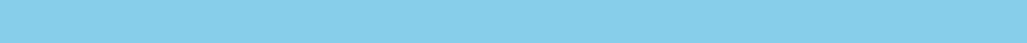

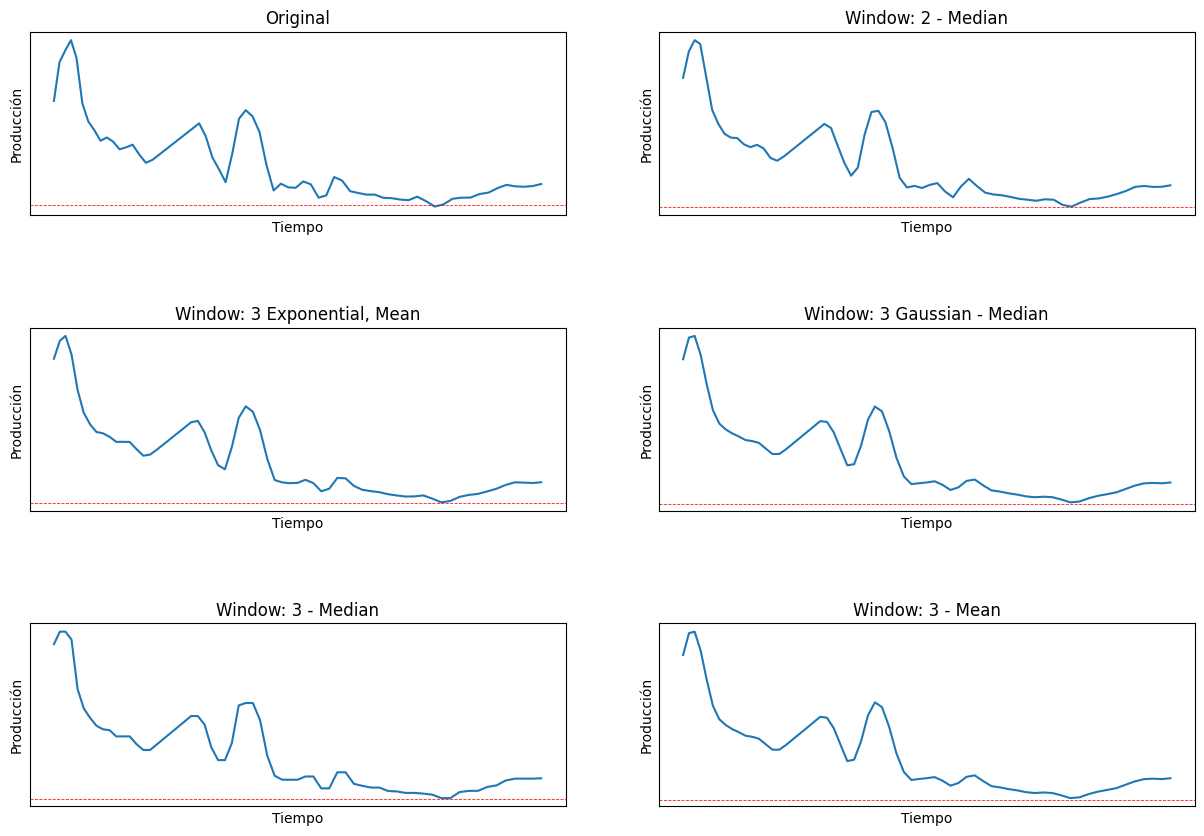

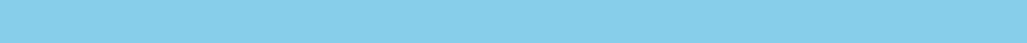

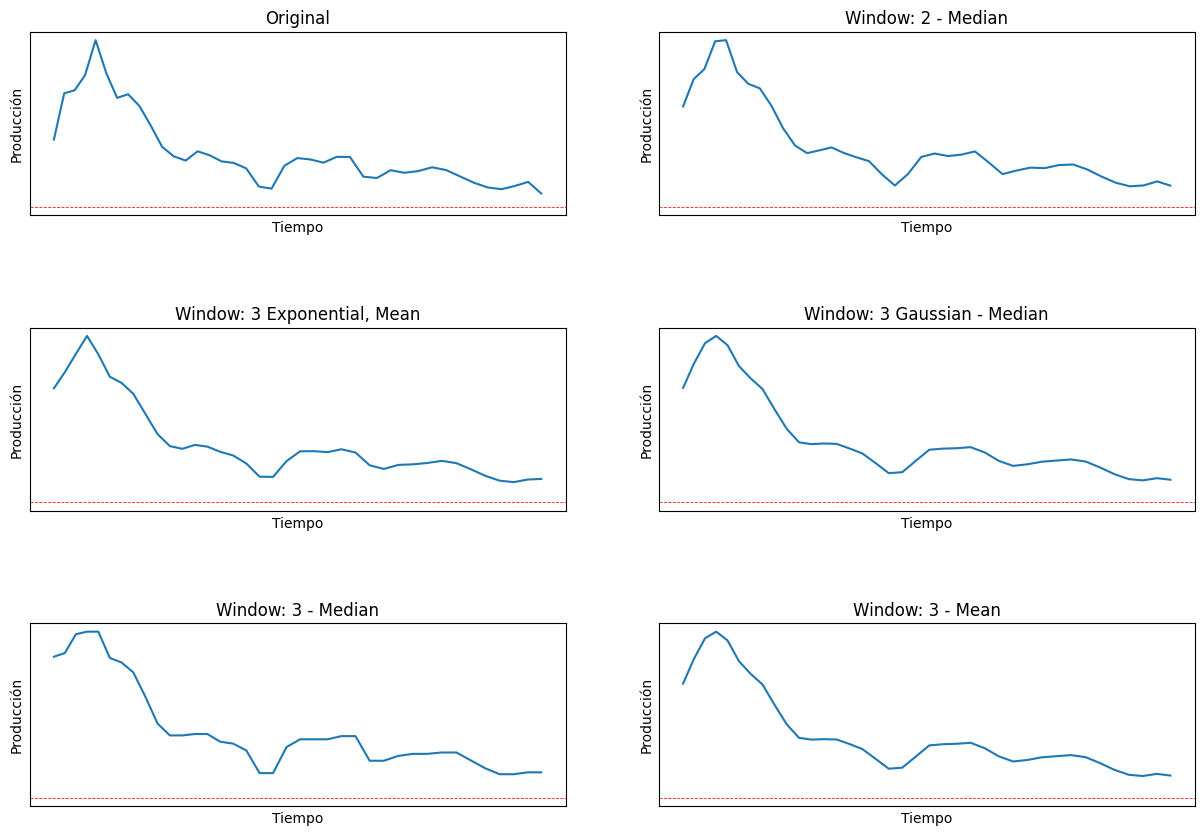

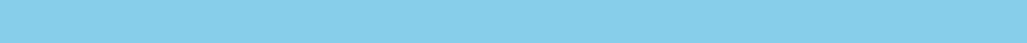

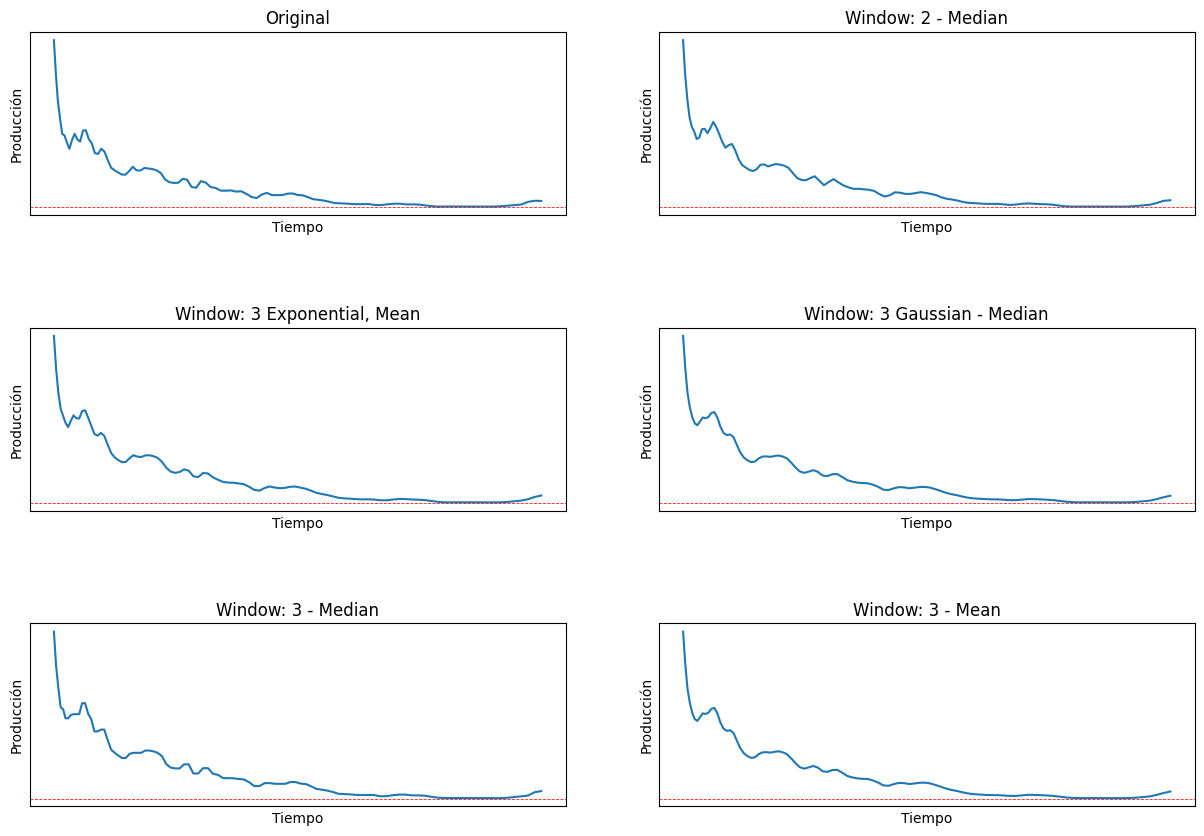

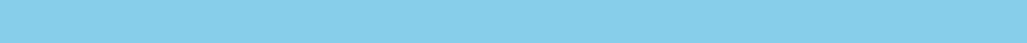

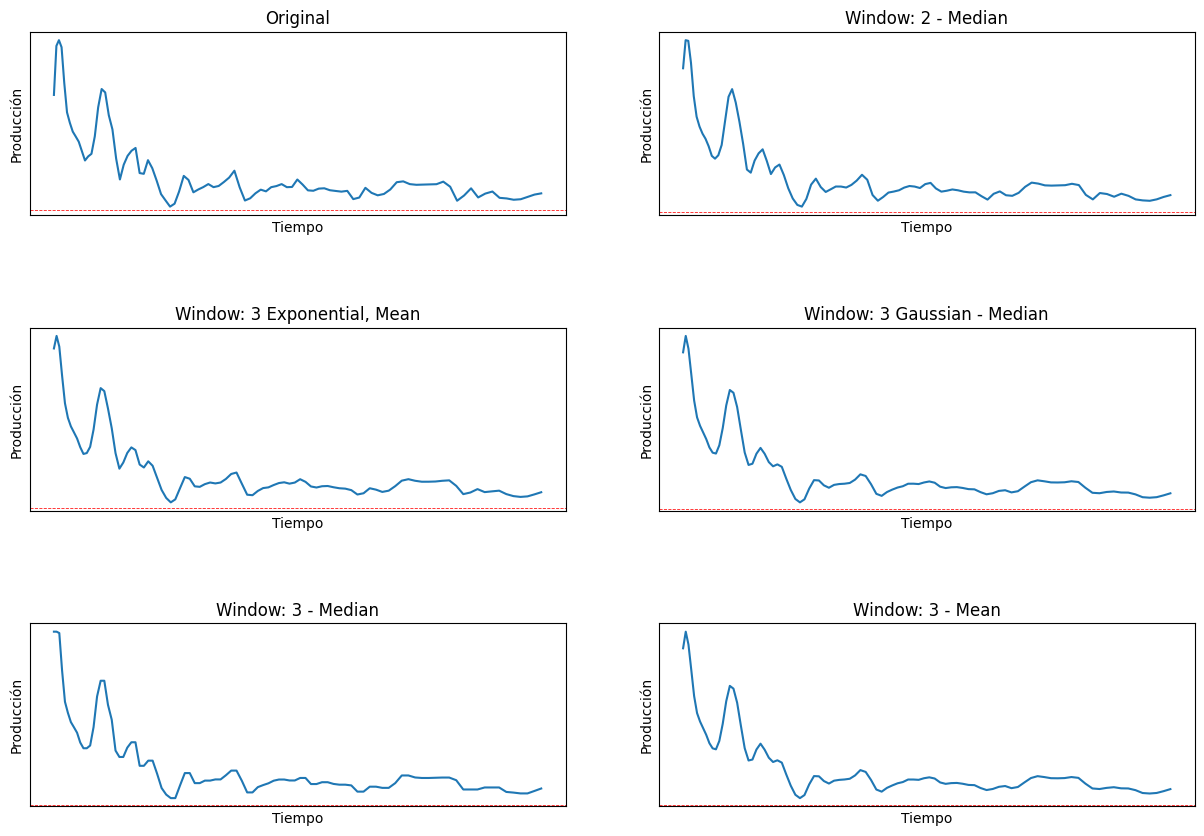

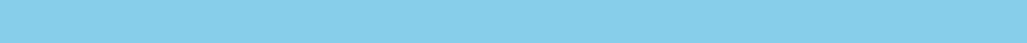

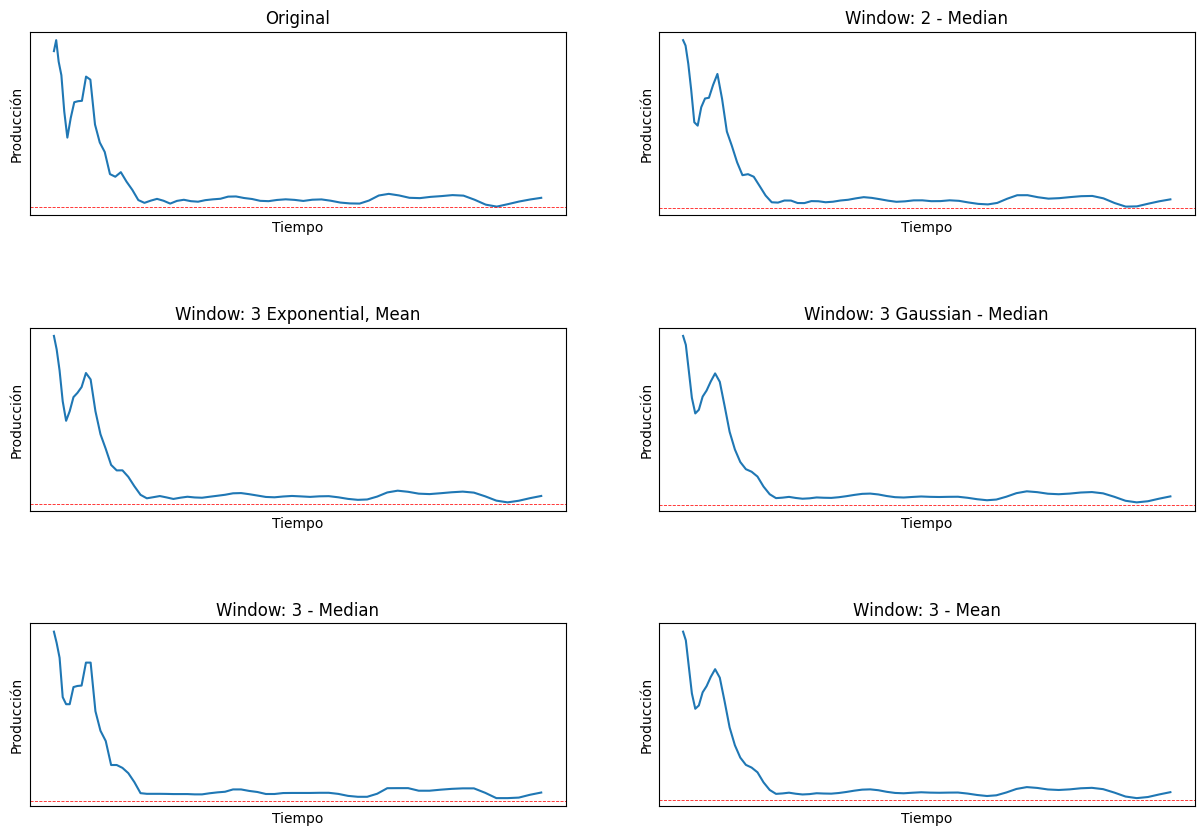

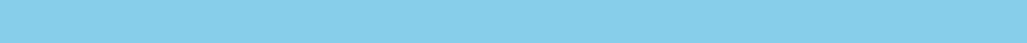

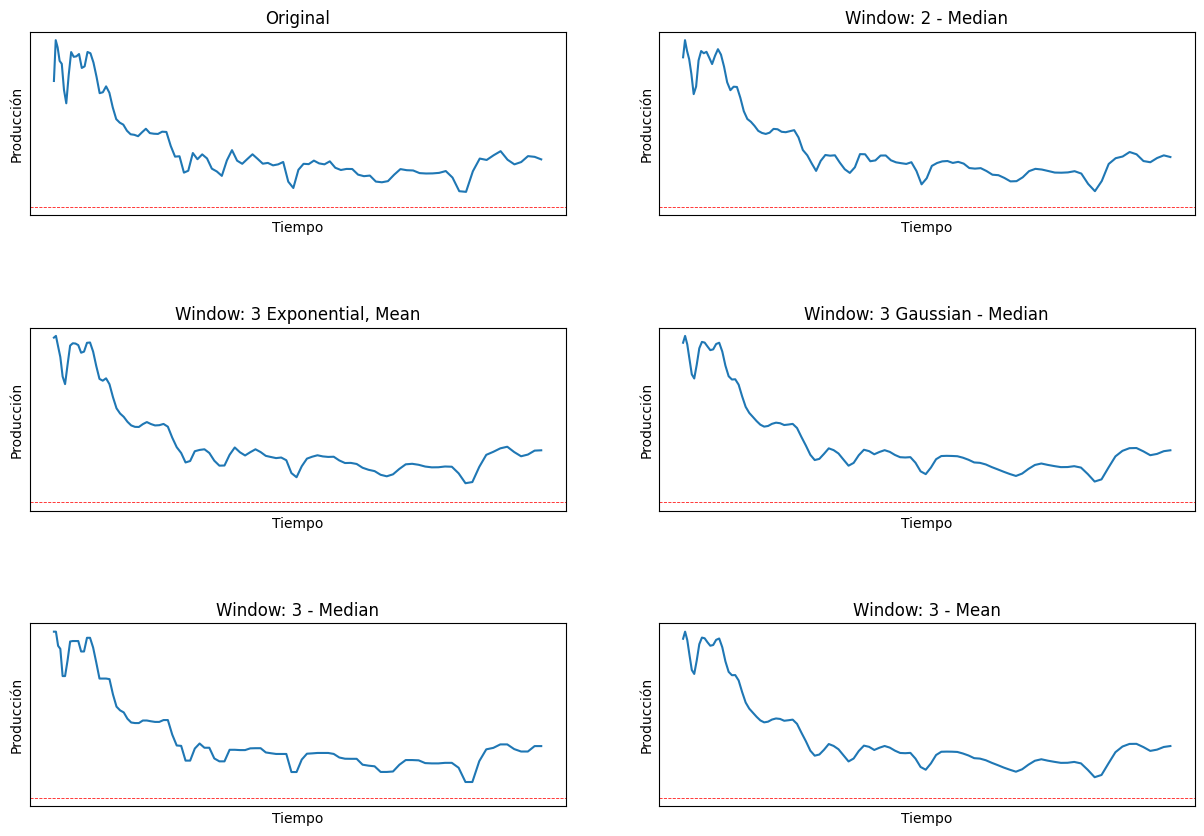

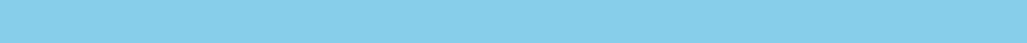

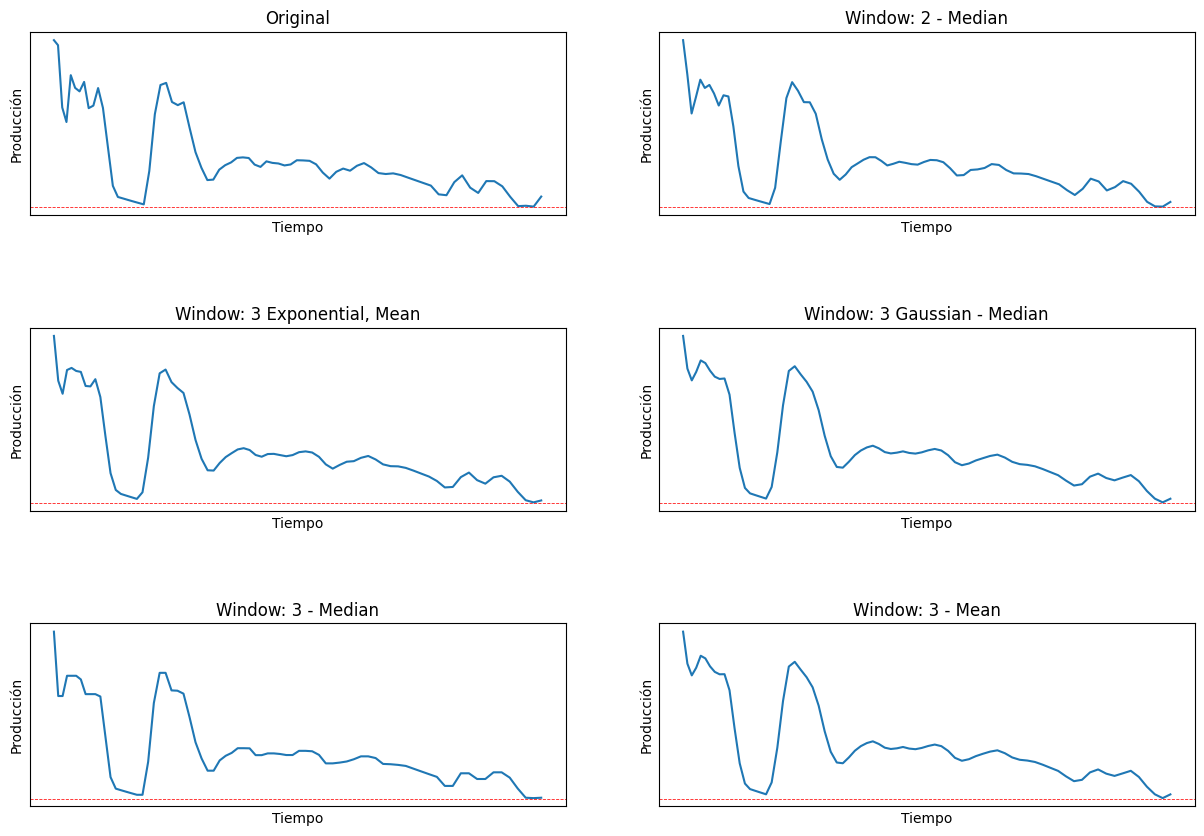

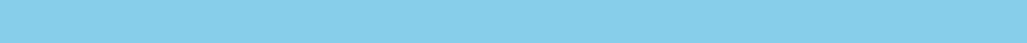

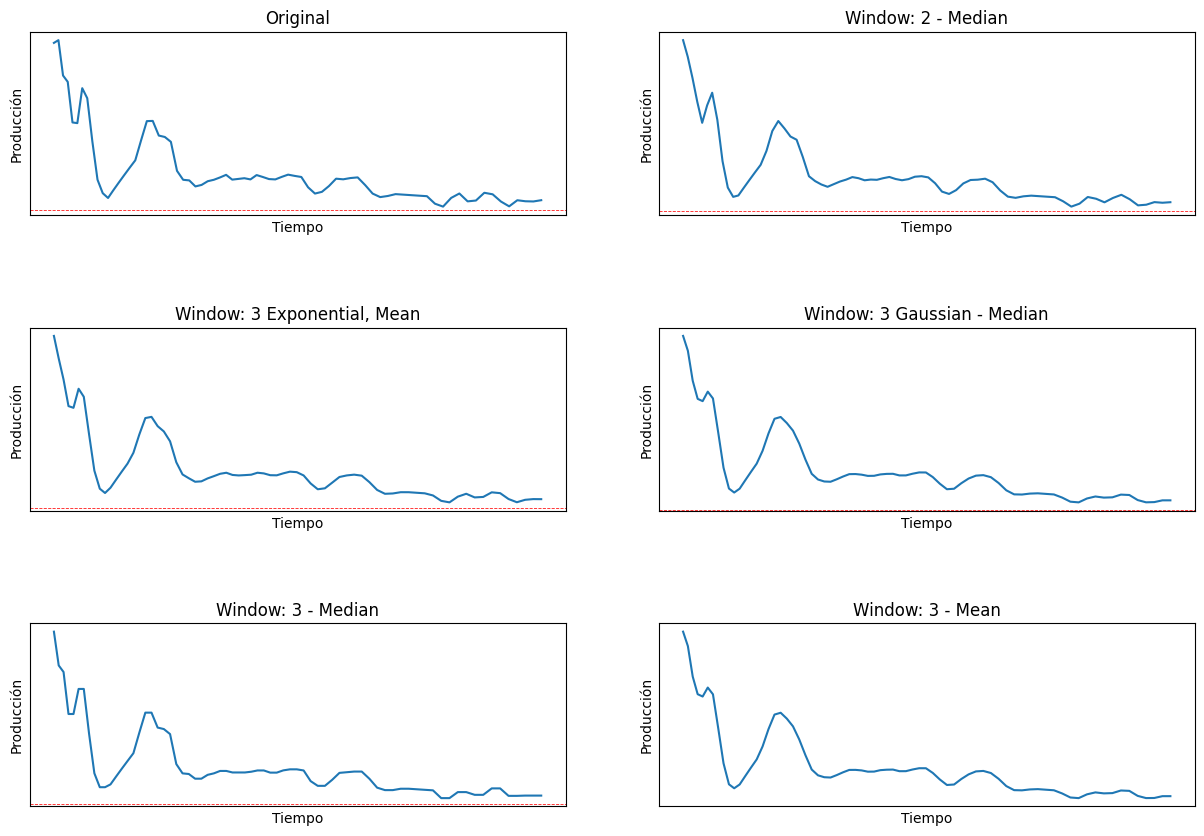

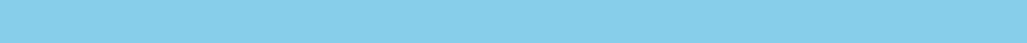

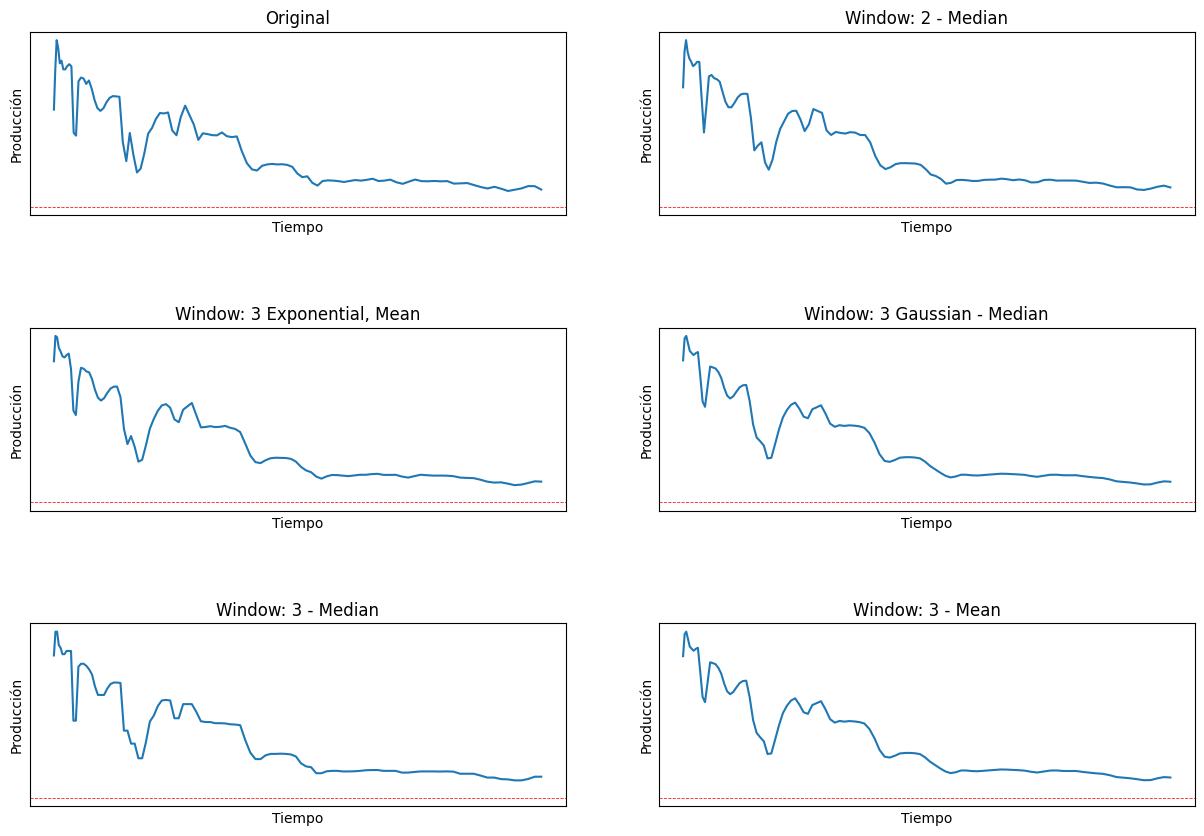

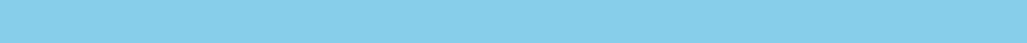

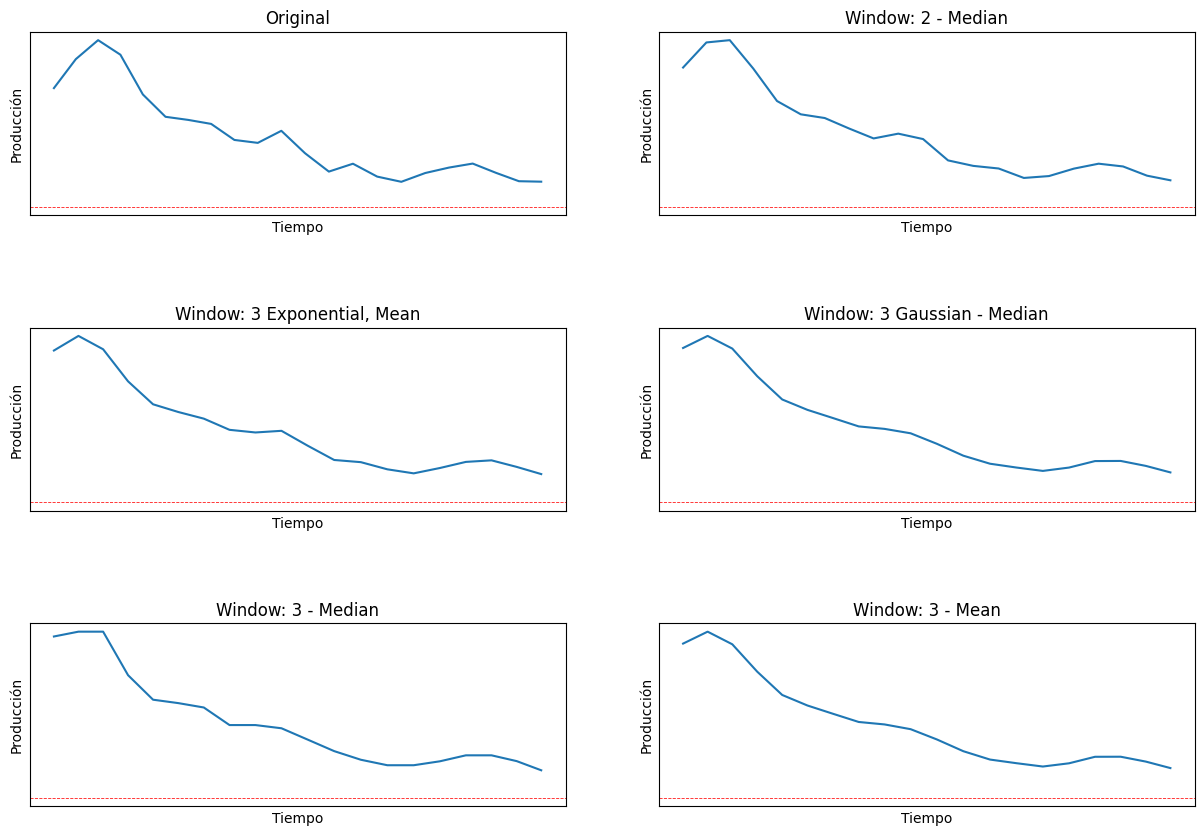

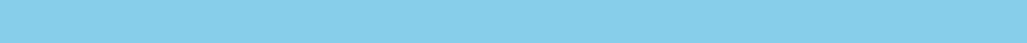

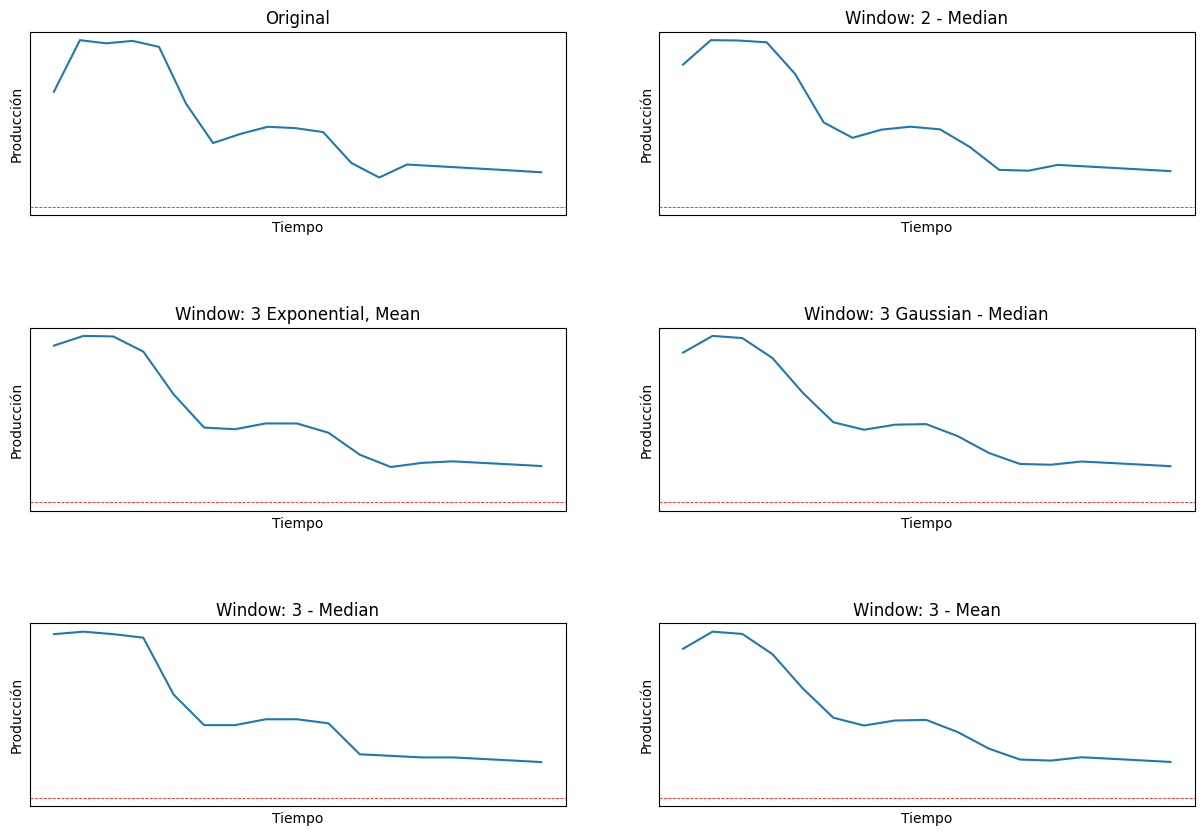

In [89]:
wells_ids = [159500, 161951, 155131, 156325, 153467, 154927, 158366, 158758, 153906, 163167, 163423]

for id in wells_ids:
  peek_well_min_prod = get_well_min_valid_prod(id)

  # Params
  fig_width = 13
  fig_height = 2 * 3

  # Title workaround
  fig, ax = plt.subplots()
  fig.set_size_inches(fig_width, 0.3)
  ax.set_axis_off()
  fig.patch.set_facecolor('skyblue')

  # Curve graphics
  fig, axes = plt.subplots(nrows=3, ncols=2)
  fig.set_size_inches(fig_width, fig_height)
  fig.tight_layout(pad=3.0)
  fig.subplots_adjust(top=1.4)

  axes[0][0].set_title("Original")
  get_prod_by_well_id(id)["prod"].plot(ax=axes[0][0], grid=True, xticks=[], yticks=[], xlabel="Tiempo", ylabel="Producción")
  axes[0][0].axhline(y=peek_well_min_prod, linewidth=0.6, color='r', alpha=0.9, linestyle='--')

  axes[0][1].set_title("Window: 2 - Median")
  get_prod_by_well_id(id)["prod"].rolling(2).median().plot(ax=axes[0][1], grid=True, xticks=[], yticks=[], xlabel="Tiempo", ylabel="Producción")
  axes[0][1].axhline(y=peek_well_min_prod, linewidth=0.6, color='r', alpha=0.9, linestyle='--')

  axes[1][0].set_title("Window: 3 Exponential, Mean")
  get_prod_by_well_id(id)["prod"].rolling(3, win_type='exponential').mean().plot(ax=axes[1][0], grid=True, xticks=[], yticks=[], xlabel="Tiempo", ylabel="Producción")
  axes[1][0].axhline(y=peek_well_min_prod, linewidth=0.6, color='r', alpha=0.9, linestyle='--')

  #axes[0][2].set_title("Window: 2 - Mean")
  #get_prod_by_well_id(id)["prod"].rolling(2).mean().plot(ax=axes[0][2], grid=True, xticks=[], yticks=[], xlabel="Tiempo", ylabel="Producción")
  #axes[0][2].axhline(y=peek_well_min_prod, linewidth=0.6, color='r', alpha=0.9, linestyle='--')

  axes[1][1].set_title("Window: 3 Gaussian - Median")
  get_prod_by_well_id(id)["prod"].rolling(3, win_type='gaussian').mean(std=3).plot(ax=axes[1][1], grid=True, xticks=[], yticks=[], xlabel="Tiempo", ylabel="Producción")
  axes[1][1].axhline(y=peek_well_min_prod, linewidth=0.6, color='r', alpha=0.9, linestyle='--')

  axes[2][0].set_title("Window: 3 - Median")
  get_prod_by_well_id(id)["prod"].rolling(3).median().plot(ax=axes[2][0], grid=True, xticks=[], yticks=[], xlabel="Tiempo", ylabel="Producción")
  axes[2][0].axhline(y=peek_well_min_prod, linewidth=0.6, color='r', alpha=0.9, linestyle='--')

  axes[2][1].set_title("Window: 3 - Mean")
  get_prod_by_well_id(id)["prod"].rolling(3).mean().plot(ax=axes[2][1], grid=True, xticks=[], yticks=[], xlabel="Tiempo", ylabel="Producción")
  axes[2][1].axhline(y=peek_well_min_prod, linewidth=0.6, color='r', alpha=0.9, linestyle='--')

In [67]:
%%time

# Sorted by date is necessary condition
prod_data.sort_values(by=['fecha', 'idpozo'], ascending=True, inplace=True)
wells_ids = prod_data['idpozo'].value_counts().index.to_list()

print("Applying rolling window to all wells...\n")

for id in wells_ids:
  well_id_mask = prod_data["idpozo"] == id
  new_prod_data = prod_data[well_id_mask]["prod"].rolling(2).median()
  prod_data.loc[well_id_mask, "prod"] = new_prod_data
  prod_type = "prod_pet" if get_well_id_type(id) == "Petrolífero" else "prod_gas"
  prod_data.loc[well_id_mask, prod_type] = new_prod_data

Applying rolling window to all wells...

CPU times: user 9.85 s, sys: 19.7 ms, total: 9.87 s
Wall time: 10.2 s


### Reaplicamos los filtros depuradores

In [68]:
%%time
apply_wells_best_period()

Filtering wells zeros periods...


Total removed entries: 304
Total affected wells: 29

Affected wells ids: [155648, 152872, 147306, 158931, 155536, 155718, 155643, 147295, 156623, 159236, 153772, 153894, 157213, 157796, 161529, 155218, 152991, 147630, 158018, 161260, 158202, 147628, 158806, 152988, 161955, 147154, 147296, 147619, 155415]

CPU times: user 24.2 s, sys: 60.9 ms, total: 24.3 s
Wall time: 24.6 s


In [69]:
remove_wells_zeros_ends(leave_last_n_zero_months=3)

Removing wells zeros ends...

Total removed entries: 2831
Total affected wells: 2719



In [70]:
remove_wells_by_min_entries_count(min_entries_count=MIN_MONTHLY_ENTRIES_COUNT)

Filtering wells with less than 9 entries...


Deleted 32 wells ids: [154555, 157105, 159099, 159865, 164234, 164235, 164236, 164303, 164335, 164336, 164337, 164348, 164349, 164363, 164364, 164376, 164397, 164399, 164404, 164406, 164407, 164408, 164415, 164416, 164440, 164441, 164442, 164443, 164444, 164498, 164499, 164500]



In [71]:
filter_wells_with_zero_total_production()

Filtering wells with all production entries zero or ~zero...

            prod
idpozo          
146213  219.8500
146774  233.4550
147486  239.4050
152852  239.4350
155540  235.7950
159868  237.8275
159910  198.4950
161333  233.8305
162109  196.8400

Deleted 9 wells ids: [146213, 146774, 147486, 152852, 155540, 159868, 159910, 161333, 162109]



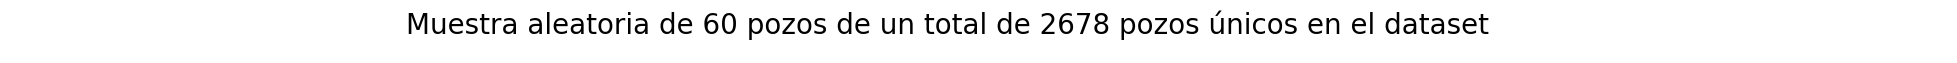

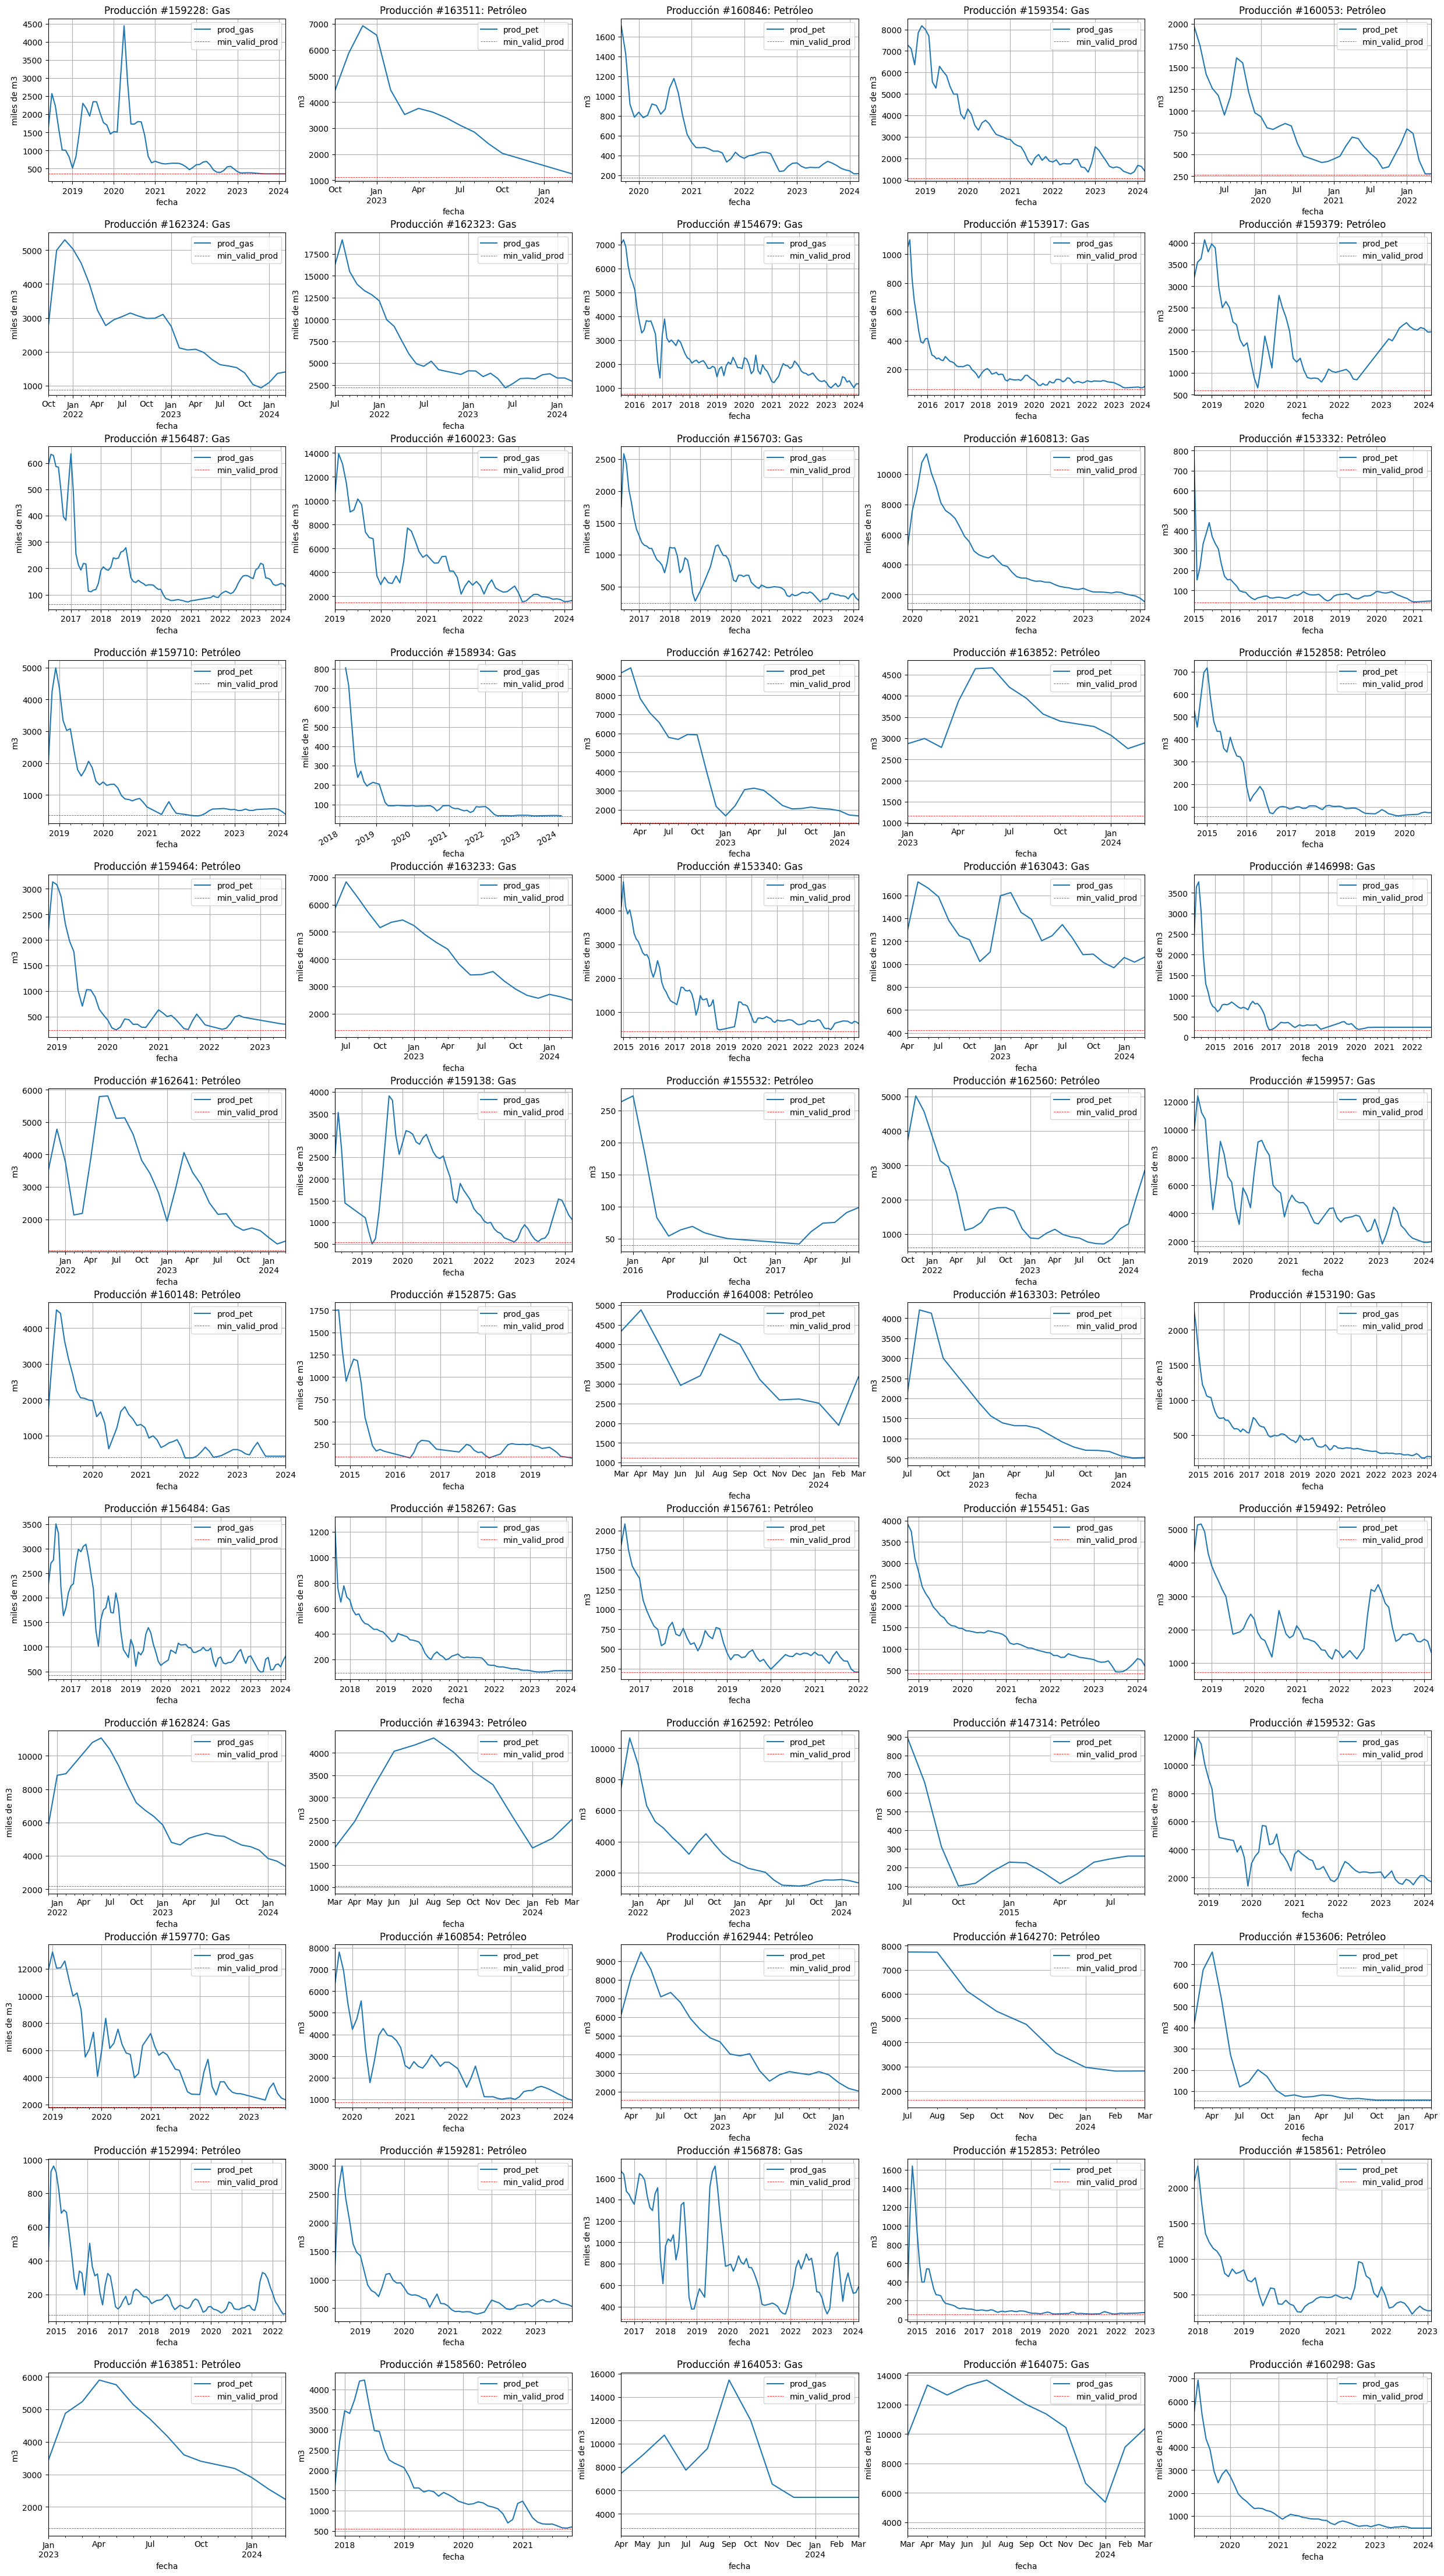

In [72]:
sample = random.sample(prod_data['idpozo'].value_counts().index.to_list(), k=60)
title = f"Muestra aleatoria de {len(sample)} pozos de un total de {len(prod_data['idpozo'].unique())} pozos únicos en el dataset"
plot_mini_wells_sample(wells_ids_sample=sample, title=title)

### Demostración gráfica del proceso de sincronización de curvas al agrupar por período

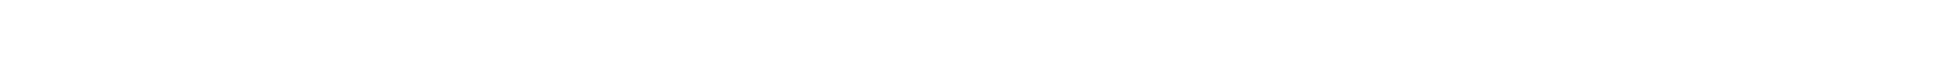

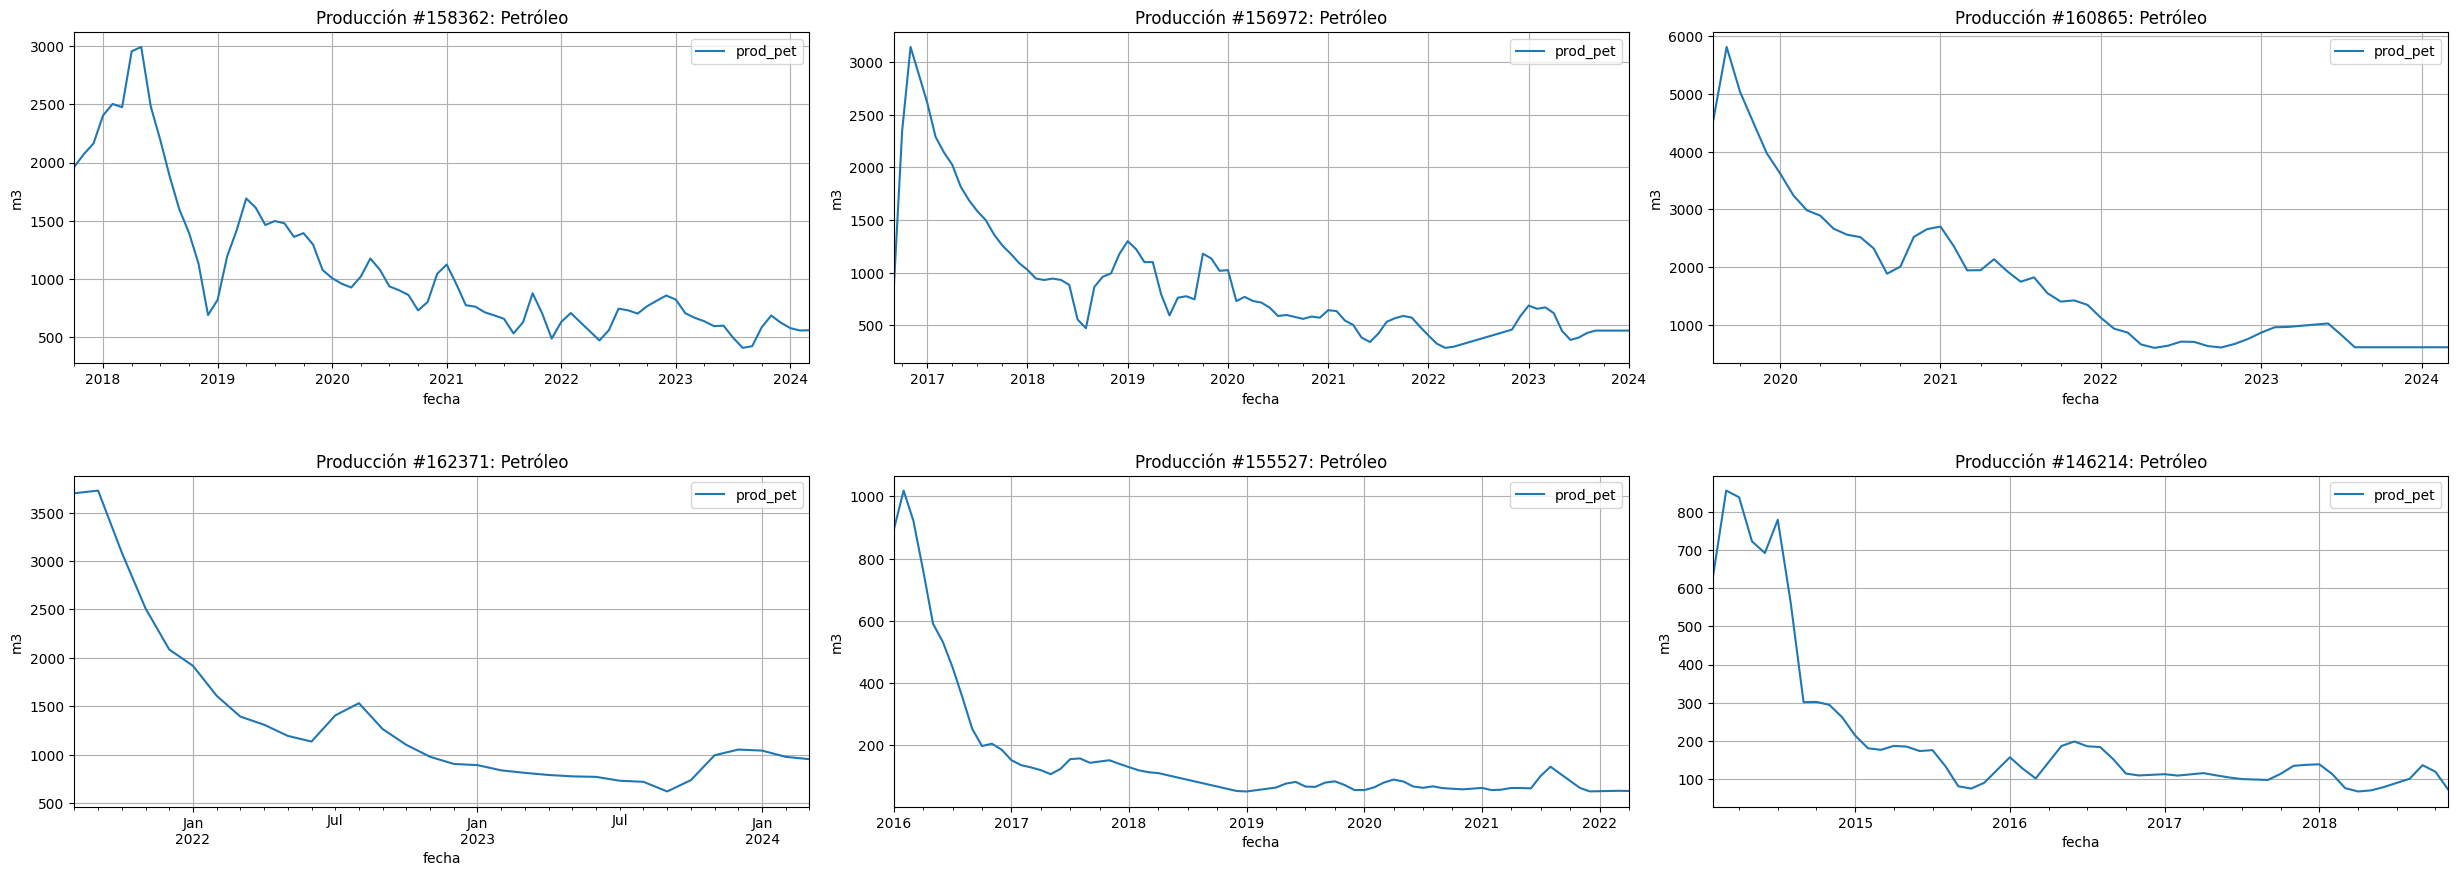

In [73]:
showcase_pet_ids = [158362, 156972, 160865, 162371, 155527, 146214]
plot_mini_wells_sample(wells_ids_sample=showcase_pet_ids, num_cols=3, show_min_valid_prod=False)

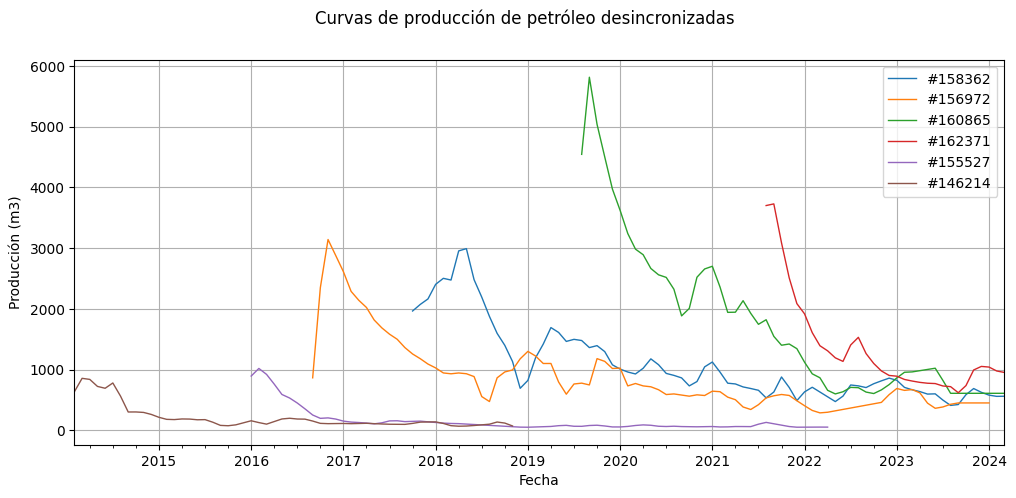

In [74]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
fig.suptitle(f"Curvas de producción de petróleo desincronizadas", fontsize=12)

for id in showcase_pet_ids:
  well_prod = prod_data[prod_data["idpozo"] == id]
  well_prod.plot(ax=ax, x="fecha", y="prod_pet", grid=True, legend=f"#{id}", lw=1)

ax.set_ylabel("Producción (m3)")
ax.set_xlabel("Fecha")

ax.legend([f"#{id}" for id in showcase_pet_ids])

plt.show()

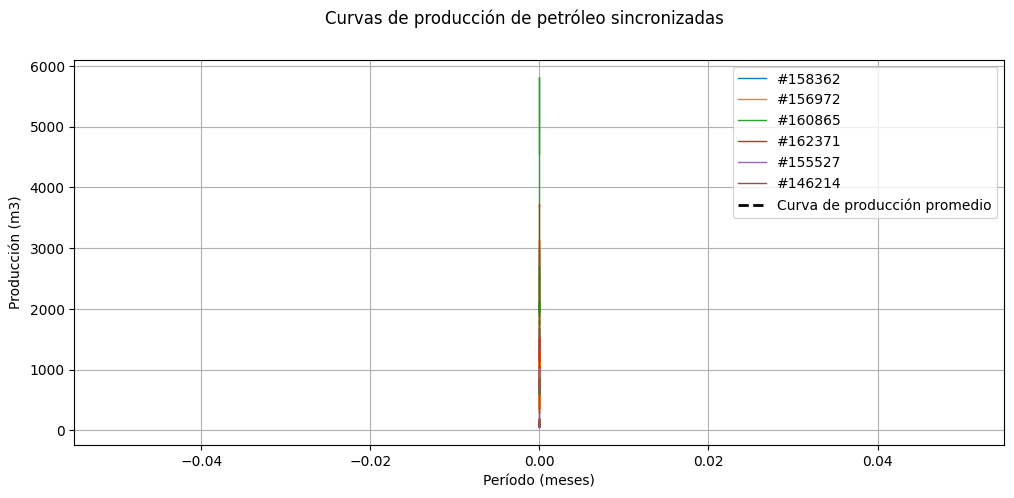

In [75]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
fig.suptitle(f"Curvas de producción de petróleo sincronizadas", fontsize=12)

for id in showcase_pet_ids:
  well_prod = prod_data[prod_data["idpozo"] == id]
  well_prod.plot(ax=ax, x="periodo", y="prod_pet", grid=True, legend=f"#{id}", lw=1)

well_prod = prod_data[prod_data["idpozo"].isin(showcase_pet_ids)]
well_prod.groupby(["periodo"])["prod_pet"].mean().plot(grid=True, color="black", lw=2, style=['--'])

ax.set_ylabel("Producción (m3)")
ax.set_xlabel("Período (meses)")

legends = [f"#{id}" for id in showcase_pet_ids]
legends.append("Curva de producción promedio")
ax.legend(legends)

plt.show()

### Generamos la columna "periodo" que contabiliza secuencialmente todo el período de producción de cada pozo desde el inicio 0 hasta el último N

In [76]:
%%time

# Sorted by date is necessary condition
prod_data.sort_values(by=['fecha', 'idpozo'], ascending=True, inplace=True)
wells_ids = prod_data['idpozo'].value_counts().index.to_list()

for id in wells_ids:
  well_id_mask = prod_data["idpozo"] == id
  prod_data.loc[well_id_mask, "periodo"] = np.arange(prod_data[well_id_mask].shape[0])

CPU times: user 2.9 s, sys: 6.91 ms, total: 2.91 s
Wall time: 2.92 s


In [77]:
print("Example:\n")
prod_data[prod_data["idpozo"] == 155411]

Example:



idpozo      fecha  periodo         prod     prod_pet  prod_gas  \
6336   155411 2015-11-01        0  1092.580000  1092.580000    423.84   
6909   155411 2015-12-01        1   864.790000   864.790000    521.34   
7523   155411 2016-01-01        2   795.505000   795.505000    305.68   
8153   155411 2016-02-01        3   529.010000   529.010000    207.59   
8809   155411 2016-03-01        4   414.985000   414.985000    218.31   
9501   155411 2016-04-01        5   395.680000   395.680000    165.37   
10205  155411 2016-05-01        6   321.245000   321.245000    195.01   
10938  155411 2016-06-01        7   322.020000   322.020000    199.12   
11687  155411 2016-07-01        8   327.210000   327.210000    200.50   
12458  155411 2016-08-01        9   276.155000   276.155000    157.17   
13248  155411 2016-09-01       10   183.265000   183.265000     93.62   
14057  155411 2016-10-01       11   122.715000   122.715000     82.99   
14881  155411 2016-11-01       12   120.075000   120.075000     77.73   
15723  155411 2016-12-01       13   120.510000   120.510000     65.62   
16587  155411 2017-01-01       14   112.962143   112.962143     64.56   
17463  155411 2017-02-01       15   112.446429   112.446429     52.42   
18352  155411 2017-03-01       16   111.930714   111.930714     61.04   
19266  155411 2017-04-01       17   111.415000   111.415000     75.11   
20194  155411 2017-05-01       18   110.899286   110.899286     81.45   
21135  155411 2017-06-01       19   110.383571   110.383571     79.04   
22101  155411 2017-07-01       20   109.867857   109.867857     92.23   
23092  155411 2017-08-01       21   115.140000   115.140000     63.34   
24098  155411 2017-09-01       22   119.260000   119.260000     54.70   
25112  155411 2017-10-01       23   117.850000   117.850000     33.27   

          tipopozo  
6336   Petrolífero  
6909   Petrolífero  
7523   Petrolífero  
8153   Petrolífero  
8809   Petrolífero  
9501   Petrolífero  
10205  Petrolífero  
10938  Petrolífero  
11687  Petrolífero  
12458  Petrolífero  
13248  Petrolífero  
14057  Petrolífero  
14881  Petrolífero  
15723  Petrolífero  
16587  Petrolífero  
17463  Petrolífero  
18352  Petrolífero  
19266  Petrolífero  
20194  Petrolífero  
21135  Petrolífero  
22101  Petrolífero  
23092  Petrolífero  
24098  Petrolífero  
25112  Petrolífero

## Vista de la agregación por promedio de todos los períodos

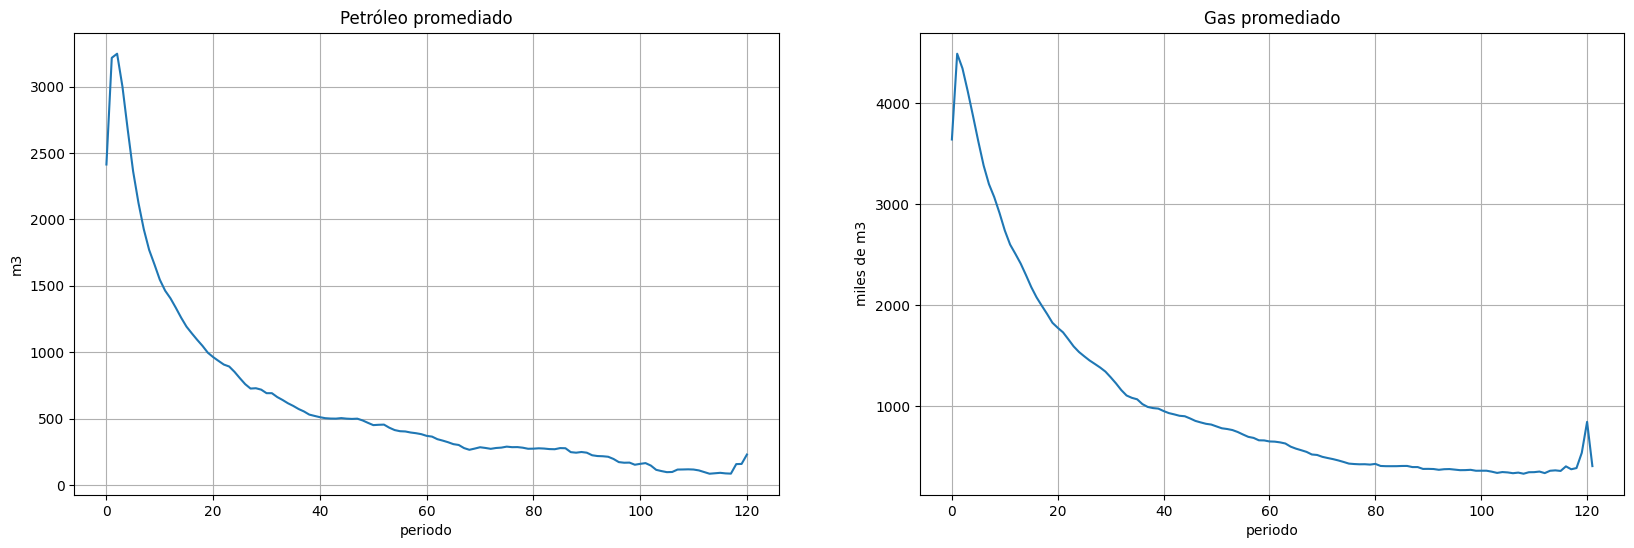

In [78]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(20, 6)
prod_data[prod_data["tipopozo"] == "Petrolífero"].groupby(["periodo"])["prod"].mean().plot(ax=axes[0], grid=True, title="Petróleo promediado", ylabel="m3")
prod_data[prod_data["tipopozo"] == "Gasífero"].groupby(["periodo"])["prod"].mean().plot(ax=axes[1], grid=True, title="Gas promediado", ylabel="miles de m3")
plt.show()

### Análisis respecto a los dos picos encontrados al final de la serie de agregación

idpozo      fecha  periodo     prod  prod_pet  prod_gas     tipopozo
136749  146224 2023-11-01      116  248.515   248.515     40.97  Petrolífero
140641  146224 2024-01-01      118  234.685   234.685     48.68  Petrolífero
142555  146224 2024-02-01      119  234.140   234.140     46.36  Petrolífero
144432  146224 2024-03-01      120  229.200   229.200      7.50  Petrolífero
138705  146224 2023-12-01      117  229.185   229.185     42.42  Petrolífero
142572  147293 2024-02-01      116   86.710    86.710      6.56  Petrolífero
144449  147293 2024-03-01      117   84.495    84.495      7.84  Petrolífero
144440  147002 2024-03-01      119   82.925    82.925     21.82  Petrolífero
140650  147002 2024-01-01      117   80.145    80.145     24.45  Petrolífero
142563  147002 2024-02-01      118   79.655    79.655     23.32  Petrolífero

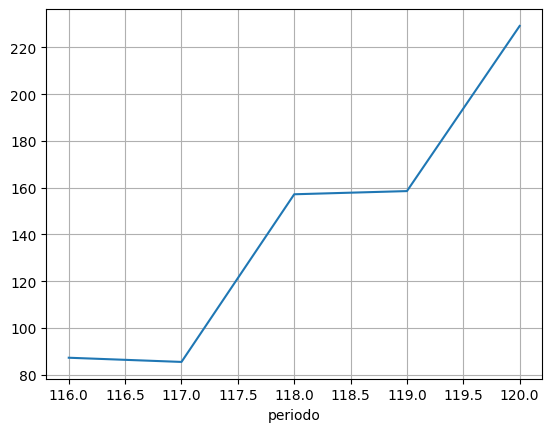

In [79]:
erratic_wells_data = prod_data[(prod_data["tipopozo"] == "Petrolífero") & (prod_data["periodo"] > 115)]
erratic_wells_data.groupby(["periodo"])["prod"].mean().plot(grid=True)
erratic_wells_data.sort_values(by="prod", ascending=False).head(10)

idpozo      fecha  periodo         prod   prod_pet     prod_gas  \
142556  146877 2024-02-01      119  1327.617500  17.370640  1327.617500   
144433  146877 2024-03-01      120  1327.555000  12.694910  1327.555000   
140643  146877 2024-01-01      118  1171.555337  13.212280  1171.555337   
138707  146877 2023-12-01      117  1106.116013   8.307650  1106.116013   
142569  147183 2024-02-01      117   761.708583   1.816494   761.708583   
144446  147183 2024-03-01      118   746.039250   1.767996   746.039250   
144454  147303 2024-03-01      117   611.335000   0.000000   611.335000   
144438  146995 2024-03-01      119   609.745000   0.000000   609.745000   
144437  146994 2024-03-01      119   532.015000   0.000000   532.015000   
140642  146872 2024-01-01      118   530.000000   0.000000   530.000000   

        tipopozo  
142556  Gasífero  
144433  Gasífero  
140643  Gasífero  
138707  Gasífero  
142569  Gasífero  
144446  Gasífero  
144454  Gasífero  
144438  Gasífero  
144437  Gasífero  
140642  Gasífero

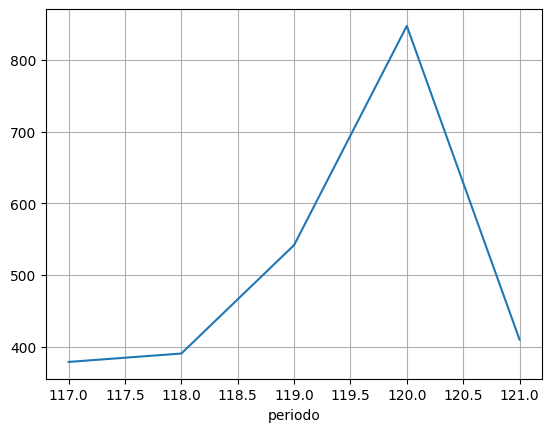

In [80]:
erratic_wells_data = prod_data[(prod_data["tipopozo"] == "Gasífero") & (prod_data["periodo"] > 116)]
erratic_wells_data.groupby(["periodo"])["prod"].mean().plot(grid=True)
erratic_wells_data.sort_values(by="prod", ascending=False).head(10)

### Removemos las últimas entradas de los pozos conflictivos

In [81]:
# Gas
delete_index_ids(prod_data[(prod_data["idpozo"] == 146877) & (prod_data["periodo"] >= 115)].index)
# delete_index_ids(prod_data[(prod_data["idpozo"] == 147183) & (prod_data["periodo"] >= 118)].index)
delete_index_ids(prod_data[(prod_data["periodo"] >= 119)].index)

# Petróleo
delete_index_ids(prod_data[(prod_data["idpozo"] == 146224) & (prod_data["periodo"] >= 117)].index)

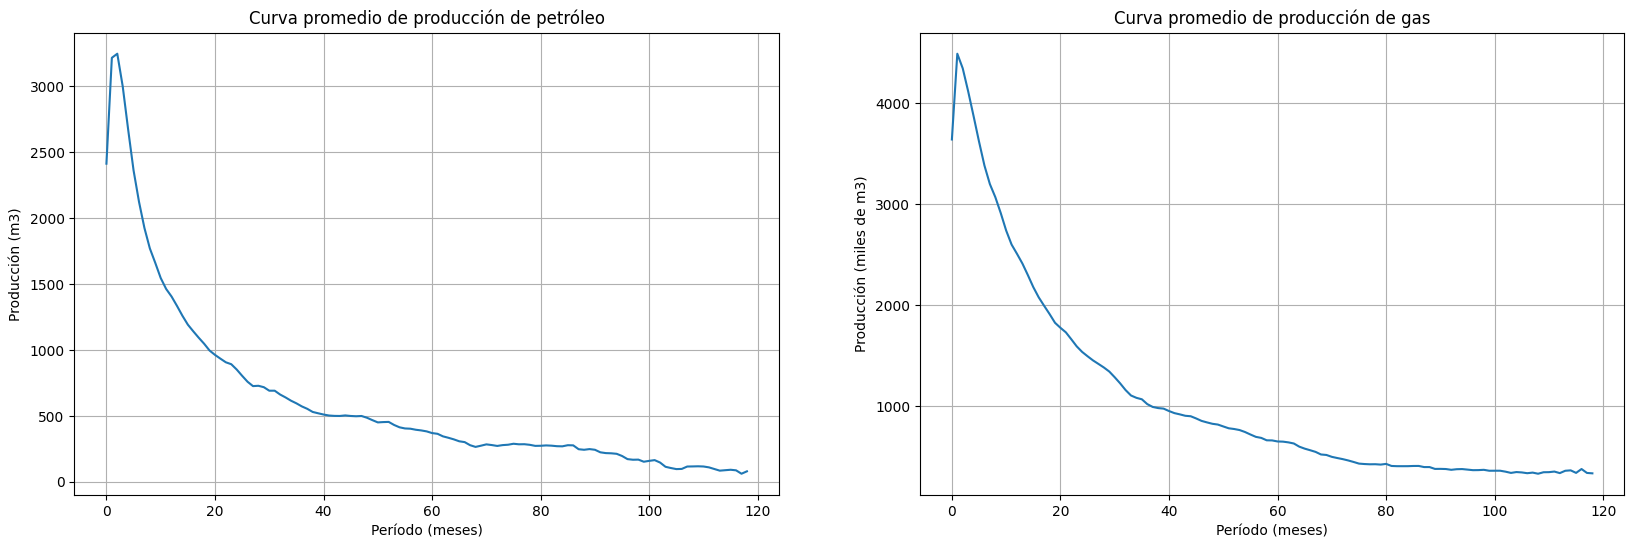

In [82]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(20, 6)
prod_data[prod_data["tipopozo"] == "Petrolífero"].groupby(["periodo"])["prod"].mean().plot(ax=axes[0], grid=True, title="Curva promedio de producción de petróleo", ylabel="Producción (m3)", xlabel="Período (meses)")
prod_data[prod_data["tipopozo"] == "Gasífero"].groupby(["periodo"])["prod"].mean().plot(ax=axes[1], grid=True, title="Curva promedio de producción de gas", ylabel="Producción (miles de m3)", xlabel="Período (meses)")
plt.show()

# Data export

In [ ]:
data.sort_values(by=['fecha', 'idpozo'], ascending=True, inplace=True)
prod_data.sort_values(by=['fecha', 'idpozo'], ascending=True, inplace=True)

# Get only resulting prod_data entries
valid_entries_to_export = prod_data.sort_index().index

# Take only resulting prod_data records from data and remove the others
data_to_export = data.loc[valid_entries_to_export]

# Sort just in case previous loc search unsorts it
data_to_export.sort_values(by=['fecha', 'idpozo'], ascending=True, inplace=True)

# Overwrite all data in prod_data columns with prod_data values
data_to_export.loc[:, prod_data.columns.to_list()] = prod_data

# Reset index to ordered 0 to N values
data_to_export.reset_index(drop=True, inplace=True)

# Export to csv prod_norm_date file
data_to_export.to_csv("/content/drive/MyDrive/Trabajo profesional/Code/data/prod_norm" + datetime.now().strftime("_%Y-%m-%d_%H:%M:%S") + ".csv")

del(valid_entries_to_export)
del(data_to_export)